In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate

from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from optuna import Study, Trial
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna

from lib.wrapper import RoundingWrapper
from lib.scoring import cross_val_splits, kicktipp_scoring
from lib.simple_models import StaticEstimator
from lib.plots import cross_val_plot
import lib.theme as theme


sampler = optuna.samplers.TPESampler(seed=1893)
np.random.seed(1893)
DEBUG = False

In [2]:
df_matches = pd.read_pickle("data/matches_train.pickle")
splits = cross_val_splits(df_matches, start=5)

## Static Results

╒═════════╤═════════╤═════════╕
│ Model   │   Score │     Std │
╞═════════╪═════════╪═════════╡
│ 2:1     │ 362.125 │ 24.6751 │
├─────────┼─────────┼─────────┤
│ 1:0     │ 354.75  │ 27.896  │
├─────────┼─────────┼─────────┤
│ 1:1     │ 224     │ 15.748  │
├─────────┼─────────┼─────────┤
│ 0:0     │ 185     │ 13.4536 │
╘═════════╧═════════╧═════════╛


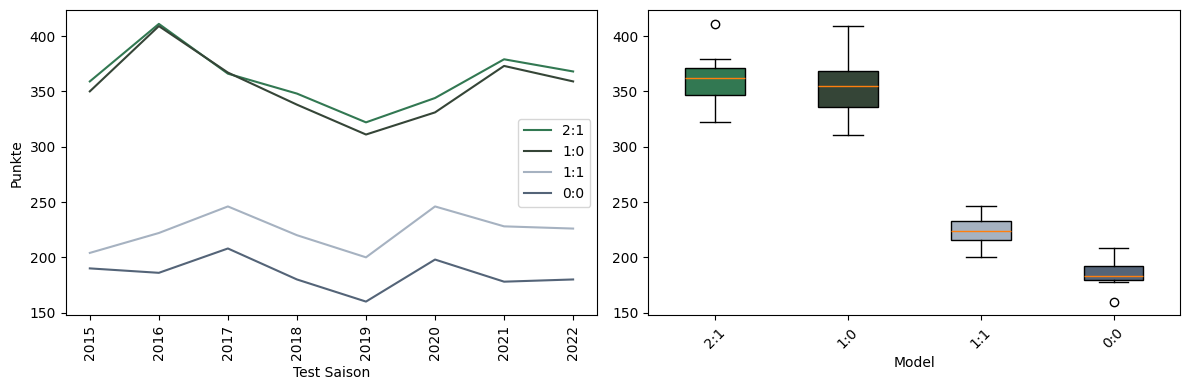

In [3]:
y_train = df_matches[["host_goals", "guest_goals"]].values

static_results = [
    [0, 0],
    [1, 1],
    [1, 0],
    [2, 1],
]

models = [StaticEstimator(result) for result in static_results]
labels = [f"{r[0]}:{r[1]}" for r in static_results]
scores = [
    cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring)
    for model in models
]

colors = [
    theme.GRAY_D,
    theme.GRAY,
    theme.GRASS_D,
    theme.GRASS,
]
cross_val_plot(df_matches, splits, labels, scores, color=colors)
!

In [4]:
X_train = df_matches.drop(columns=["host_name", "guest_name", "host_goals", "guest_goals"])
y_train = df_matches[["host_goals", "guest_goals"]].values
features = [
    "diff_last_season_goals",
    "diff_last_season_points",
    "diff_horizon_points",
    "diff_horizon_goals",
]
X_train = X_train[features]
X_train.tail()

,diff_last_season_goals,diff_last_season_points,diff_horizon_points,diff_horizon_goals
id,,,,
64166,-45.0,-25.0,-38.666667,-53.000000
64167,72.0,58.0,-27.500000,-31.500000
64168,-17.0,-13.0,-8.000000,-5.833333
64169,50.0,57.0,18.333333,8.000000
64170,6.0,9.0,14.333333,8.666667


## Random Forest

In [5]:
def objective(trial):
    rf_criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"]
    )
    rf_max_depth = trial.suggest_int("max_depth", 2, 15)
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 75)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
    estimator = RoundingWrapper(
        RandomForestRegressor(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
            n_jobs=4,
        )
    )
    scores = cross_val_score(
        estimator, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring
    )
    return np.mean(scores)


rf_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="rf", sampler=sampler
)
rf_study.optimize(objective, n_trials=1 if DEBUG else 200)
result = {"score": rf_study.best_value, **rf_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))

[I 2024-09-17 00:00:31,018] A new study created in RDB with name: rf


[I 2024-09-17 00:00:40,343] Trial 0 finished with value: 338.25 and parameters: {'criterion': 'absolute_error', 'max_depth': 13, 'n_estimators': 30, 'min_samples_split': 93}. Best is trial 0 with value: 338.25.


[I 2024-09-17 00:00:40,876] Trial 1 finished with value: 366.25 and parameters: {'criterion': 'poisson', 'max_depth': 14, 'n_estimators': 23, 'min_samples_split': 72}. Best is trial 1 with value: 366.25.


[I 2024-09-17 00:00:41,358] Trial 2 finished with value: 366.125 and parameters: {'criterion': 'squared_error', 'max_depth': 15, 'n_estimators': 13, 'min_samples_split': 47}. Best is trial 1 with value: 366.25.


[I 2024-09-17 00:00:41,948] Trial 3 finished with value: 338.875 and parameters: {'criterion': 'squared_error', 'max_depth': 14, 'n_estimators': 23, 'min_samples_split': 3}. Best is trial 1 with value: 366.25.


[I 2024-09-17 00:00:42,699] Trial 4 finished with value: 364.25 and parameters: {'criterion': 'poisson', 'max_depth': 10, 'n_estimators': 37, 'min_samples_split': 31}. Best is trial 1 with value: 366.25.


[I 2024-09-17 00:00:43,330] Trial 5 finished with value: 363.375 and parameters: {'criterion': 'squared_error', 'max_depth': 13, 'n_estimators': 17, 'min_samples_split': 37}. Best is trial 1 with value: 366.25.


[I 2024-09-17 00:00:43,922] Trial 6 finished with value: 369.25 and parameters: {'criterion': 'squared_error', 'max_depth': 11, 'n_estimators': 11, 'min_samples_split': 77}. Best is trial 6 with value: 369.25.


[I 2024-09-17 00:00:46,853] Trial 7 finished with value: 332.5 and parameters: {'criterion': 'absolute_error', 'max_depth': 7, 'n_estimators': 13, 'min_samples_split': 99}. Best is trial 6 with value: 369.25.


[I 2024-09-17 00:00:47,506] Trial 8 finished with value: 360.25 and parameters: {'criterion': 'friedman_mse', 'max_depth': 13, 'n_estimators': 24, 'min_samples_split': 18}. Best is trial 6 with value: 369.25.


[I 2024-09-17 00:00:48,253] Trial 9 finished with value: 367.0 and parameters: {'criterion': 'friedman_mse', 'max_depth': 11, 'n_estimators': 35, 'min_samples_split': 39}. Best is trial 6 with value: 369.25.


[I 2024-09-17 00:00:48,887] Trial 10 finished with value: 385.125 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 56, 'min_samples_split': 68}. Best is trial 10 with value: 385.125.


[I 2024-09-17 00:00:49,535] Trial 11 finished with value: 387.0 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 59, 'min_samples_split': 70}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:00:50,124] Trial 12 finished with value: 384.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 59, 'min_samples_split': 64}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:00:50,669] Trial 13 finished with value: 383.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 56, 'min_samples_split': 62}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:00:51,262] Trial 14 finished with value: 381.125 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 49, 'min_samples_split': 83}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:00:52,026] Trial 15 finished with value: 386.625 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 72, 'min_samples_split': 57}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:00:52,675] Trial 16 finished with value: 381.125 and parameters: {'criterion': 'poisson', 'max_depth': 5, 'n_estimators': 74, 'min_samples_split': 49}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:00:53,353] Trial 17 finished with value: 370.625 and parameters: {'criterion': 'friedman_mse', 'max_depth': 7, 'n_estimators': 74, 'min_samples_split': 57}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:01:00,109] Trial 18 finished with value: 332.5 and parameters: {'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 66, 'min_samples_split': 86}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:01:00,795] Trial 19 finished with value: 375.875 and parameters: {'criterion': 'squared_error', 'max_depth': 7, 'n_estimators': 65, 'min_samples_split': 51}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:01:01,363] Trial 20 finished with value: 385.25 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 49, 'min_samples_split': 23}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:01:02,025] Trial 21 finished with value: 379.5 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 46, 'min_samples_split': 23}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:01:02,755] Trial 22 finished with value: 378.5 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 66, 'min_samples_split': 9}. Best is trial 11 with value: 387.0.


[I 2024-09-17 00:01:03,374] Trial 23 finished with value: 387.75 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 51, 'min_samples_split': 39}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:03,991] Trial 24 finished with value: 385.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 61, 'min_samples_split': 57}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:04,683] Trial 25 finished with value: 382.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 70, 'min_samples_split': 39}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:05,399] Trial 26 finished with value: 366.625 and parameters: {'criterion': 'friedman_mse', 'max_depth': 8, 'n_estimators': 52, 'min_samples_split': 72}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:15,518] Trial 27 finished with value: 339.875 and parameters: {'criterion': 'absolute_error', 'max_depth': 6, 'n_estimators': 62, 'min_samples_split': 43}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:16,166] Trial 28 finished with value: 379.875 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 39, 'min_samples_split': 60}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:31,265] Trial 29 finished with value: 342.625 and parameters: {'criterion': 'absolute_error', 'max_depth': 9, 'n_estimators': 70, 'min_samples_split': 31}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:31,873] Trial 30 finished with value: 387.5 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 43, 'min_samples_split': 84}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:32,478] Trial 31 finished with value: 386.625 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 43, 'min_samples_split': 85}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:33,030] Trial 32 finished with value: 382.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 53, 'min_samples_split': 91}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:33,626] Trial 33 finished with value: 387.5 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 33, 'min_samples_split': 76}. Best is trial 23 with value: 387.75.


[I 2024-09-17 00:01:34,165] Trial 34 finished with value: 388.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 32, 'min_samples_split': 77}. Best is trial 34 with value: 388.25.


[I 2024-09-17 00:01:34,752] Trial 35 finished with value: 380.75 and parameters: {'criterion': 'poisson', 'max_depth': 6, 'n_estimators': 30, 'min_samples_split': 99}. Best is trial 34 with value: 388.25.


[I 2024-09-17 00:01:35,274] Trial 36 finished with value: 383.125 and parameters: {'criterion': 'squared_error', 'max_depth': 6, 'n_estimators': 31, 'min_samples_split': 78}. Best is trial 34 with value: 388.25.


[I 2024-09-17 00:01:35,813] Trial 37 finished with value: 383.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 26, 'min_samples_split': 93}. Best is trial 34 with value: 388.25.


[I 2024-09-17 00:01:36,409] Trial 38 finished with value: 384.25 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 41, 'min_samples_split': 78}. Best is trial 34 with value: 388.25.


[I 2024-09-17 00:01:36,951] Trial 39 finished with value: 386.75 and parameters: {'criterion': 'poisson', 'max_depth': 4, 'n_estimators': 34, 'min_samples_split': 75}. Best is trial 34 with value: 388.25.


[I 2024-09-17 00:01:37,515] Trial 40 finished with value: 385.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 20, 'min_samples_split': 90}. Best is trial 34 with value: 388.25.


[I 2024-09-17 00:01:38,078] Trial 41 finished with value: 388.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 43, 'min_samples_split': 71}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:38,682] Trial 42 finished with value: 386.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 44, 'min_samples_split': 84}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:39,299] Trial 43 finished with value: 381.0 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 37, 'min_samples_split': 80}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:39,993] Trial 44 finished with value: 370.75 and parameters: {'criterion': 'squared_error', 'max_depth': 15, 'n_estimators': 33, 'min_samples_split': 67}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:40,548] Trial 45 finished with value: 353.375 and parameters: {'criterion': 'friedman_mse', 'max_depth': 3, 'n_estimators': 26, 'min_samples_split': 74}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:41,123] Trial 46 finished with value: 386.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 47, 'min_samples_split': 66}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:46,922] Trial 47 finished with value: 330.5 and parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 38, 'min_samples_split': 71}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:47,460] Trial 48 finished with value: 388.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 42, 'min_samples_split': 95}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:48,163] Trial 49 finished with value: 371.375 and parameters: {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 41, 'min_samples_split': 96}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:48,800] Trial 50 finished with value: 386.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 52, 'min_samples_split': 89}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:49,386] Trial 51 finished with value: 388.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 29, 'min_samples_split': 82}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:49,989] Trial 52 finished with value: 384.875 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 29, 'min_samples_split': 97}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:50,446] Trial 53 finished with value: 382.875 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 16, 'min_samples_split': 82}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:51,065] Trial 54 finished with value: 384.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 46, 'min_samples_split': 87}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:51,673] Trial 55 finished with value: 351.875 and parameters: {'criterion': 'friedman_mse', 'max_depth': 4, 'n_estimators': 41, 'min_samples_split': 94}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:52,300] Trial 56 finished with value: 355.75 and parameters: {'criterion': 'squared_error', 'max_depth': 14, 'n_estimators': 36, 'min_samples_split': 45}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:52,888] Trial 57 finished with value: 385.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 50, 'min_samples_split': 31}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:53,481] Trial 58 finished with value: 387.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 45, 'min_samples_split': 82}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:54,181] Trial 59 finished with value: 372.125 and parameters: {'criterion': 'poisson', 'max_depth': 10, 'n_estimators': 55, 'min_samples_split': 100}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:54,769] Trial 60 finished with value: 375.75 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 27, 'min_samples_split': 55}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:55,387] Trial 61 finished with value: 383.25 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 32, 'min_samples_split': 77}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:55,852] Trial 62 finished with value: 382.875 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 21, 'min_samples_split': 87}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:56,388] Trial 63 finished with value: 386.375 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 39, 'min_samples_split': 69}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:01:56,931] Trial 64 finished with value: 384.875 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 35, 'min_samples_split': 63}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:02:00,788] Trial 65 finished with value: 328.625 and parameters: {'criterion': 'absolute_error', 'max_depth': 4, 'n_estimators': 28, 'min_samples_split': 80}. Best is trial 41 with value: 388.375.


[I 2024-09-17 00:02:01,313] Trial 66 finished with value: 388.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 23, 'min_samples_split': 74}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:01,755] Trial 67 finished with value: 385.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 23, 'min_samples_split': 33}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:02,187] Trial 68 finished with value: 351.5 and parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'n_estimators': 19, 'min_samples_split': 73}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:02,613] Trial 69 finished with value: 385.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 13, 'min_samples_split': 92}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:03,179] Trial 70 finished with value: 384.875 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 49, 'min_samples_split': 50}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:03,784] Trial 71 finished with value: 380.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 25, 'min_samples_split': 76}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:04,416] Trial 72 finished with value: 385.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 42, 'min_samples_split': 80}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:04,990] Trial 73 finished with value: 380.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 30, 'min_samples_split': 87}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:05,578] Trial 74 finished with value: 385.625 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 33, 'min_samples_split': 61}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:06,156] Trial 75 finished with value: 385.625 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 39, 'min_samples_split': 70}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:06,733] Trial 76 finished with value: 381.125 and parameters: {'criterion': 'poisson', 'max_depth': 2, 'n_estimators': 47, 'min_samples_split': 66}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:07,353] Trial 77 finished with value: 380.875 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 22, 'min_samples_split': 83}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:12,683] Trial 78 finished with value: 330.125 and parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 36, 'min_samples_split': 39}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:13,210] Trial 79 finished with value: 385.75 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 24, 'min_samples_split': 75}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:13,758] Trial 80 finished with value: 384.875 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 43, 'min_samples_split': 25}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:14,355] Trial 81 finished with value: 386.625 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 45, 'min_samples_split': 80}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:14,985] Trial 82 finished with value: 386.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 50, 'min_samples_split': 82}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:15,571] Trial 83 finished with value: 385.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 40, 'min_samples_split': 85}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:16,205] Trial 84 finished with value: 385.875 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 44, 'min_samples_split': 72}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:16,748] Trial 85 finished with value: 384.75 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 18, 'min_samples_split': 95}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:17,444] Trial 86 finished with value: 388.125 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 47, 'min_samples_split': 89}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:18,063] Trial 87 finished with value: 371.0 and parameters: {'criterion': 'friedman_mse', 'max_depth': 6, 'n_estimators': 54, 'min_samples_split': 90}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:18,726] Trial 88 finished with value: 381.875 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 57, 'min_samples_split': 53}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:19,328] Trial 89 finished with value: 383.0 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 31, 'min_samples_split': 89}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:19,919] Trial 90 finished with value: 386.0 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 48, 'min_samples_split': 42}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:20,624] Trial 91 finished with value: 381.5 and parameters: {'criterion': 'squared_error', 'max_depth': 8, 'n_estimators': 43, 'min_samples_split': 79}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:21,240] Trial 92 finished with value: 383.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 50, 'min_samples_split': 83}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:21,891] Trial 93 finished with value: 383.125 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 45, 'min_samples_split': 76}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:22,495] Trial 94 finished with value: 387.875 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 52, 'min_samples_split': 93}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:23,105] Trial 95 finished with value: 386.625 and parameters: {'criterion': 'poisson', 'max_depth': 2, 'n_estimators': 37, 'min_samples_split': 97}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:23,713] Trial 96 finished with value: 381.75 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 53, 'min_samples_split': 92}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:29,850] Trial 97 finished with value: 327.625 and parameters: {'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 59, 'min_samples_split': 98}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:30,439] Trial 98 finished with value: 382.625 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 28, 'min_samples_split': 94}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:31,047] Trial 99 finished with value: 382.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 51, 'min_samples_split': 89}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:31,585] Trial 100 finished with value: 386.625 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 48, 'min_samples_split': 5}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:32,251] Trial 101 finished with value: 385.5 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 46, 'min_samples_split': 86}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:32,855] Trial 102 finished with value: 384.5 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 34, 'min_samples_split': 78}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:33,450] Trial 103 finished with value: 384.875 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 41, 'min_samples_split': 82}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:34,118] Trial 104 finished with value: 380.75 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 52, 'min_samples_split': 73}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:34,781] Trial 105 finished with value: 383.125 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 45, 'min_samples_split': 88}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:35,383] Trial 106 finished with value: 387.5 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 48, 'min_samples_split': 84}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:35,962] Trial 107 finished with value: 354.875 and parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'n_estimators': 55, 'min_samples_split': 91}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:36,529] Trial 108 finished with value: 382.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 48, 'min_samples_split': 36}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:37,006] Trial 109 finished with value: 367.0 and parameters: {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 15, 'min_samples_split': 85}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:37,630] Trial 110 finished with value: 383.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 58, 'min_samples_split': 93}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:38,277] Trial 111 finished with value: 383.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 47, 'min_samples_split': 68}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:38,855] Trial 112 finished with value: 385.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 51, 'min_samples_split': 84}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:39,444] Trial 113 finished with value: 382.5 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 42, 'min_samples_split': 81}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:39,997] Trial 114 finished with value: 383.125 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 38, 'min_samples_split': 77}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:40,517] Trial 115 finished with value: 383.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 44, 'min_samples_split': 74}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:41,162] Trial 116 finished with value: 384.625 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 49, 'min_samples_split': 14}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:41,813] Trial 117 finished with value: 384.625 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 31, 'min_samples_split': 79}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:44,867] Trial 118 finished with value: 329.125 and parameters: {'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 26, 'min_samples_split': 100}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:45,375] Trial 119 finished with value: 385.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 29, 'min_samples_split': 87}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:45,979] Trial 120 finished with value: 386.5 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 40, 'min_samples_split': 65}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:46,481] Trial 121 finished with value: 388.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 46, 'min_samples_split': 71}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:47,068] Trial 122 finished with value: 383.25 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 46, 'min_samples_split': 71}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:47,611] Trial 123 finished with value: 385.875 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 44, 'min_samples_split': 75}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:48,338] Trial 124 finished with value: 362.75 and parameters: {'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 53, 'min_samples_split': 27}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:49,046] Trial 125 finished with value: 385.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 49, 'min_samples_split': 69}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:49,653] Trial 126 finished with value: 377.25 and parameters: {'criterion': 'squared_error', 'max_depth': 7, 'n_estimators': 47, 'min_samples_split': 48}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:50,221] Trial 127 finished with value: 386.0 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 42, 'min_samples_split': 96}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:50,764] Trial 128 finished with value: 386.875 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 45, 'min_samples_split': 84}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:51,333] Trial 129 finished with value: 358.125 and parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'n_estimators': 51, 'min_samples_split': 90}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:51,845] Trial 130 finished with value: 384.875 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 24, 'min_samples_split': 59}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:52,484] Trial 131 finished with value: 384.5 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 65, 'min_samples_split': 72}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:53,104] Trial 132 finished with value: 382.0 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 63, 'min_samples_split': 77}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:53,689] Trial 133 finished with value: 385.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 35, 'min_samples_split': 64}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:54,316] Trial 134 finished with value: 388.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 56, 'min_samples_split': 81}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:54,931] Trial 135 finished with value: 384.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 55, 'min_samples_split': 82}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:55,593] Trial 136 finished with value: 385.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 57, 'min_samples_split': 81}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:56,143] Trial 137 finished with value: 379.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 32, 'min_samples_split': 78}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:56,761] Trial 138 finished with value: 381.0 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 54, 'min_samples_split': 86}. Best is trial 66 with value: 388.75.


[I 2024-09-17 00:02:57,408] Trial 139 finished with value: 390.125 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 48, 'min_samples_split': 80}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:02:58,131] Trial 140 finished with value: 372.875 and parameters: {'criterion': 'poisson', 'max_depth': 9, 'n_estimators': 48, 'min_samples_split': 75}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:02:58,695] Trial 141 finished with value: 384.0 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 50, 'min_samples_split': 80}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:02:59,345] Trial 142 finished with value: 381.875 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 43, 'min_samples_split': 84}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:02:59,868] Trial 143 finished with value: 384.25 and parameters: {'criterion': 'poisson', 'max_depth': 2, 'n_estimators': 52, 'min_samples_split': 79}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:00,559] Trial 144 finished with value: 386.0 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 46, 'min_samples_split': 83}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:01,176] Trial 145 finished with value: 383.75 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 21, 'min_samples_split': 88}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:01,601] Trial 146 finished with value: 381.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 10, 'min_samples_split': 73}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:06,560] Trial 147 finished with value: 330.0 and parameters: {'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 47, 'min_samples_split': 91}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:07,117] Trial 148 finished with value: 382.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 40, 'min_samples_split': 76}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:07,760] Trial 149 finished with value: 386.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 49, 'min_samples_split': 93}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:08,319] Trial 150 finished with value: 388.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 45, 'min_samples_split': 86}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:08,884] Trial 151 finished with value: 385.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 45, 'min_samples_split': 86}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:09,491] Trial 152 finished with value: 382.5 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 43, 'min_samples_split': 88}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:10,044] Trial 153 finished with value: 386.625 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 44, 'min_samples_split': 82}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:10,606] Trial 154 finished with value: 387.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 47, 'min_samples_split': 45}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:11,202] Trial 155 finished with value: 387.0 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 51, 'min_samples_split': 80}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:11,801] Trial 156 finished with value: 384.25 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 60, 'min_samples_split': 85}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:12,447] Trial 157 finished with value: 385.875 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 48, 'min_samples_split': 78}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:12,982] Trial 158 finished with value: 351.625 and parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'n_estimators': 41, 'min_samples_split': 70}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:13,633] Trial 159 finished with value: 384.625 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 46, 'min_samples_split': 95}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:14,160] Trial 160 finished with value: 383.125 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 28, 'min_samples_split': 90}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:14,788] Trial 161 finished with value: 382.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 62, 'min_samples_split': 67}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:15,381] Trial 162 finished with value: 385.5 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 57, 'min_samples_split': 74}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:15,995] Trial 163 finished with value: 388.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 53, 'min_samples_split': 77}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:16,579] Trial 164 finished with value: 386.5 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 50, 'min_samples_split': 76}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:17,212] Trial 165 finished with value: 382.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 54, 'min_samples_split': 82}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:17,809] Trial 166 finished with value: 381.875 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 53, 'min_samples_split': 80}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:18,383] Trial 167 finished with value: 382.0 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 33, 'min_samples_split': 77}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:18,989] Trial 168 finished with value: 387.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 45, 'min_samples_split': 84}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:19,668] Trial 169 finished with value: 386.0 and parameters: {'criterion': 'poisson', 'max_depth': 2, 'n_estimators': 56, 'min_samples_split': 71}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:20,323] Trial 170 finished with value: 380.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 38, 'min_samples_split': 86}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:20,904] Trial 171 finished with value: 383.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 51, 'min_samples_split': 74}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:21,563] Trial 172 finished with value: 383.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 59, 'min_samples_split': 72}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:22,116] Trial 173 finished with value: 386.25 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 48, 'min_samples_split': 69}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:22,843] Trial 174 finished with value: 386.625 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 53, 'min_samples_split': 78}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:23,456] Trial 175 finished with value: 386.125 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 56, 'min_samples_split': 81}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:24,073] Trial 176 finished with value: 384.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 44, 'min_samples_split': 92}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:27,524] Trial 177 finished with value: 324.0 and parameters: {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 42, 'min_samples_split': 83}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:28,162] Trial 178 finished with value: 384.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 49, 'min_samples_split': 88}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:28,779] Trial 179 finished with value: 383.5 and parameters: {'criterion': 'squared_error', 'max_depth': 6, 'n_estimators': 52, 'min_samples_split': 79}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:29,385] Trial 180 finished with value: 384.375 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 46, 'min_samples_split': 98}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:30,023] Trial 181 finished with value: 385.875 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 46, 'min_samples_split': 44}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:30,641] Trial 182 finished with value: 385.5 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 47, 'min_samples_split': 51}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:31,273] Trial 183 finished with value: 386.0 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 49, 'min_samples_split': 41}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:31,842] Trial 184 finished with value: 388.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 30, 'min_samples_split': 46}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:32,314] Trial 185 finished with value: 380.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 30, 'min_samples_split': 38}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:32,859] Trial 186 finished with value: 379.625 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 26, 'min_samples_split': 35}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:33,359] Trial 187 finished with value: 384.75 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 33, 'min_samples_split': 77}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:33,928] Trial 188 finished with value: 388.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 28, 'min_samples_split': 54}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:34,424] Trial 189 finished with value: 385.875 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 29, 'min_samples_split': 40}. Best is trial 139 with value: 390.125.


[I 2024-09-17 00:03:35,025] Trial 190 finished with value: 391.25 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 31, 'min_samples_split': 54}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:35,591] Trial 191 finished with value: 387.375 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 29, 'min_samples_split': 47}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:36,192] Trial 192 finished with value: 385.125 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 31, 'min_samples_split': 56}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:36,846] Trial 193 finished with value: 383.75 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 32, 'min_samples_split': 54}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:37,426] Trial 194 finished with value: 384.625 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 28, 'min_samples_split': 52}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:37,992] Trial 195 finished with value: 381.0 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 27, 'min_samples_split': 57}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:38,613] Trial 196 finished with value: 360.0 and parameters: {'criterion': 'friedman_mse', 'max_depth': 11, 'n_estimators': 24, 'min_samples_split': 32}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:39,172] Trial 197 finished with value: 387.75 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 35, 'min_samples_split': 47}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:39,850] Trial 198 finished with value: 368.0 and parameters: {'criterion': 'squared_error', 'max_depth': 15, 'n_estimators': 35, 'min_samples_split': 50}. Best is trial 190 with value: 391.25.


[I 2024-09-17 00:03:40,469] Trial 199 finished with value: 388.375 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'n_estimators': 34, 'min_samples_split': 48}. Best is trial 190 with value: 391.25.


╒═════════╤═══════════════╤═════════════╤════════════════╤═════════════════════╕
│   score │ criterion     │   max_depth │   n_estimators │   min_samples_split │
╞═════════╪═══════════════╪═════════════╪════════════════╪═════════════════════╡
│  391.25 │ squared_error │           3 │             31 │                  54 │
╘═════════╧═══════════════╧═════════════╧════════════════╧═════════════════════╛


In [6]:
def build_rf_model(study):
    best_params = study.best_params
    return RoundingWrapper(
        RandomForestRegressor(
            n_estimators=best_params["n_estimators"],
            criterion=best_params["criterion"],
            max_depth=best_params["max_depth"],
            min_samples_split=best_params["min_samples_split"],
            n_jobs=4,
        )
    )

## Gradient Boosting

In [7]:
def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 25, 300)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda = trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha = trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingWrapper(
            XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                learning_rate=learning_rate,
                max_leaves=num_leaves,
                min_child_weight=min_child_weight,
                objective=trial.suggest_categorical(
                    "objective-xgb",
                    ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"],
                ),
            )
        )
    elif algo == "lgbm":
        estimator = RoundingWrapper(
            MultiOutputRegressor(
                LGBMRegressor(
                    verbose=-1,
                    n_jobs=-1,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda,
                    learning_rate=learning_rate,
                    num_leaves=num_leaves,
                    min_child_weight=min_child_weight,
                    objective=trial.suggest_categorical(
                        "objective-lgbm", ["rmse", "mae", "poisson", "mape"]
                    ),
                )
            )
        )

    scores = cross_val_score(
        estimator, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring
    )
    return np.mean(scores)


gb_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="gb", sampler=sampler
)
gb_study.optimize(objective, n_trials=1 if DEBUG else 400)
result = {"score": gb_study.best_value, **gb_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))

[I 2024-09-17 00:03:40,501] A new study created in RDB with name: gb


[I 2024-09-17 00:03:41,402] Trial 0 finished with value: 313.0 and parameters: {'algo': 'xgb', 'n_estimators': 282, 'max_depth': 6, 'lambda': 0.8218009875074701, 'alpha': 0.3487303791611496, 'learning_rate': 0.47622278494765435, 'num_leaves': 12, 'min_child_weight': 6.738306917032328, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 0 with value: 313.0.


[I 2024-09-17 00:03:42,016] Trial 1 finished with value: 328.125 and parameters: {'algo': 'xgb', 'n_estimators': 96, 'max_depth': 5, 'lambda': 1.1331141409145007, 'alpha': 0.6984916324035089, 'learning_rate': 0.4409729795704762, 'num_leaves': 20, 'min_child_weight': 11.522498056085013, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 1 with value: 328.125.


[I 2024-09-17 00:03:42,373] Trial 2 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 147, 'max_depth': 6, 'lambda': 0.7649531358696224, 'alpha': 0.3190113225472262, 'learning_rate': 0.004279962110754487, 'num_leaves': 5, 'min_child_weight': 10.502538536294296, 'objective-lgbm': 'mape'}. Best is trial 1 with value: 328.125.


[I 2024-09-17 00:03:42,615] Trial 3 finished with value: 348.375 and parameters: {'algo': 'lgbm', 'n_estimators': 38, 'max_depth': 8, 'lambda': 0.34578976760997593, 'alpha': 1.4956518170497266, 'learning_rate': 0.2209185096940945, 'num_leaves': 28, 'min_child_weight': 6.4061018716628695, 'objective-lgbm': 'poisson'}. Best is trial 3 with value: 348.375.


[I 2024-09-17 00:03:43,022] Trial 4 finished with value: 331.75 and parameters: {'algo': 'xgb', 'n_estimators': 195, 'max_depth': 2, 'lambda': 0.46657389885704736, 'alpha': 1.144440575290176, 'learning_rate': 0.40800363363954034, 'num_leaves': 15, 'min_child_weight': 14.653682328371918, 'objective-xgb': 'reg:squarederror'}. Best is trial 3 with value: 348.375.


[I 2024-09-17 00:03:43,609] Trial 5 finished with value: 240.0 and parameters: {'algo': 'lgbm', 'n_estimators': 185, 'max_depth': 4, 'lambda': 1.9937680276229879, 'alpha': 1.0508686370431168, 'learning_rate': 0.3528714067444559, 'num_leaves': 10, 'min_child_weight': 11.159353443251014, 'objective-lgbm': 'mape'}. Best is trial 3 with value: 348.375.


[I 2024-09-17 00:03:43,863] Trial 6 finished with value: 363.5 and parameters: {'algo': 'xgb', 'n_estimators': 46, 'max_depth': 7, 'lambda': 1.5882144069369946, 'alpha': 0.16243155578212876, 'learning_rate': 0.08796292686796886, 'num_leaves': 25, 'min_child_weight': 1.1470922632172997, 'objective-xgb': 'reg:squarederror'}. Best is trial 6 with value: 363.5.


[I 2024-09-17 00:03:44,157] Trial 7 finished with value: 368.25 and parameters: {'algo': 'lgbm', 'n_estimators': 256, 'max_depth': 2, 'lambda': 0.01916863741779351, 'alpha': 1.0131214829801913, 'learning_rate': 0.18382177926854265, 'num_leaves': 6, 'min_child_weight': 7.81764075471979, 'objective-lgbm': 'poisson'}. Best is trial 7 with value: 368.25.


[I 2024-09-17 00:03:44,390] Trial 8 finished with value: 324.125 and parameters: {'algo': 'xgb', 'n_estimators': 81, 'max_depth': 7, 'lambda': 1.000981385002758, 'alpha': 0.6800475919358471, 'learning_rate': 0.49703850831577534, 'num_leaves': 7, 'min_child_weight': 11.70080043438673, 'objective-xgb': 'reg:squarederror'}. Best is trial 7 with value: 368.25.


[I 2024-09-17 00:03:44,636] Trial 9 finished with value: 360.5 and parameters: {'algo': 'lgbm', 'n_estimators': 197, 'max_depth': 2, 'lambda': 1.9250512226405216, 'alpha': 1.7399894270174994, 'learning_rate': 0.32806800122066715, 'num_leaves': 25, 'min_child_weight': 3.827604470416812, 'objective-lgbm': 'poisson'}. Best is trial 7 with value: 368.25.


[I 2024-09-17 00:03:44,896] Trial 10 finished with value: 372.375 and parameters: {'algo': 'lgbm', 'n_estimators': 289, 'max_depth': 12, 'lambda': 0.2184808578835298, 'alpha': 1.968605656563915, 'learning_rate': 0.19354989779751122, 'num_leaves': 2, 'min_child_weight': 3.7385671835495766, 'objective-lgbm': 'rmse'}. Best is trial 10 with value: 372.375.


[I 2024-09-17 00:03:45,146] Trial 11 finished with value: 369.375 and parameters: {'algo': 'lgbm', 'n_estimators': 296, 'max_depth': 12, 'lambda': 0.029381071230168893, 'alpha': 1.9807397489115508, 'learning_rate': 0.1863980197796479, 'num_leaves': 2, 'min_child_weight': 3.7877806022788505, 'objective-lgbm': 'rmse'}. Best is trial 10 with value: 372.375.


[I 2024-09-17 00:03:45,396] Trial 12 finished with value: 371.25 and parameters: {'algo': 'lgbm', 'n_estimators': 297, 'max_depth': 13, 'lambda': 0.04329641231266315, 'alpha': 1.9815721759186364, 'learning_rate': 0.15712374164301093, 'num_leaves': 2, 'min_child_weight': 0.13672848646128788, 'objective-lgbm': 'rmse'}. Best is trial 10 with value: 372.375.


[I 2024-09-17 00:03:45,613] Trial 13 finished with value: 373.25 and parameters: {'algo': 'lgbm', 'n_estimators': 243, 'max_depth': 15, 'lambda': 0.3833724315696846, 'alpha': 1.495658495816023, 'learning_rate': 0.13908182065794564, 'num_leaves': 2, 'min_child_weight': 0.2741007742285956, 'objective-lgbm': 'rmse'}. Best is trial 13 with value: 373.25.


[I 2024-09-17 00:03:46,153] Trial 14 finished with value: 328.75 and parameters: {'algo': 'lgbm', 'n_estimators': 239, 'max_depth': 15, 'lambda': 0.44945820756574184, 'alpha': 1.4636019763488206, 'learning_rate': 0.10378341525133425, 'num_leaves': 11, 'min_child_weight': 2.9691867319724015, 'objective-lgbm': 'rmse'}. Best is trial 13 with value: 373.25.


[I 2024-09-17 00:03:46,937] Trial 15 finished with value: 314.875 and parameters: {'algo': 'lgbm', 'n_estimators': 237, 'max_depth': 11, 'lambda': 0.31891225005521584, 'alpha': 1.4633532115124939, 'learning_rate': 0.2774657998354072, 'num_leaves': 16, 'min_child_weight': 1.881464007497695, 'objective-lgbm': 'mae'}. Best is trial 13 with value: 373.25.


[I 2024-09-17 00:03:47,157] Trial 16 finished with value: 373.875 and parameters: {'algo': 'lgbm', 'n_estimators': 255, 'max_depth': 15, 'lambda': 0.6629559326329056, 'alpha': 1.7094870032681164, 'learning_rate': 0.07168751583803623, 'num_leaves': 2, 'min_child_weight': 5.2465188822274245, 'objective-lgbm': 'rmse'}. Best is trial 16 with value: 373.875.


[I 2024-09-17 00:03:47,451] Trial 17 finished with value: 370.125 and parameters: {'algo': 'lgbm', 'n_estimators': 145, 'max_depth': 15, 'lambda': 0.7034397934480264, 'alpha': 1.692856413517232, 'learning_rate': 0.03296191503276896, 'num_leaves': 7, 'min_child_weight': 5.639887552418883, 'objective-lgbm': 'rmse'}. Best is trial 16 with value: 373.875.


[I 2024-09-17 00:03:48,259] Trial 18 finished with value: 321.125 and parameters: {'algo': 'lgbm', 'n_estimators': 216, 'max_depth': 10, 'lambda': 1.2647507893549994, 'alpha': 1.3269875961121318, 'learning_rate': 0.1107513994370108, 'num_leaves': 20, 'min_child_weight': 5.3701283915518, 'objective-lgbm': 'mae'}. Best is trial 16 with value: 373.875.


[I 2024-09-17 00:03:48,631] Trial 19 finished with value: 327.875 and parameters: {'algo': 'lgbm', 'n_estimators': 258, 'max_depth': 14, 'lambda': 0.5682652618604532, 'alpha': 1.689704286556326, 'learning_rate': 0.26251432867778146, 'num_leaves': 5, 'min_child_weight': 8.72163718056446, 'objective-lgbm': 'rmse'}. Best is trial 16 with value: 373.875.


[I 2024-09-17 00:03:49,086] Trial 20 finished with value: 349.0 and parameters: {'algo': 'lgbm', 'n_estimators': 216, 'max_depth': 10, 'lambda': 1.3383654588087106, 'alpha': 1.2552728520791772, 'learning_rate': 0.07103836266641697, 'num_leaves': 9, 'min_child_weight': 0.16008182522802522, 'objective-lgbm': 'rmse'}. Best is trial 16 with value: 373.875.


[I 2024-09-17 00:03:49,423] Trial 21 finished with value: 349.0 and parameters: {'algo': 'lgbm', 'n_estimators': 268, 'max_depth': 13, 'lambda': 0.29331017686693595, 'alpha': 1.8207650656036276, 'learning_rate': 0.14770957594188144, 'num_leaves': 4, 'min_child_weight': 4.587102416637835, 'objective-lgbm': 'rmse'}. Best is trial 16 with value: 373.875.


[I 2024-09-17 00:03:49,647] Trial 22 finished with value: 377.875 and parameters: {'algo': 'lgbm', 'n_estimators': 232, 'max_depth': 14, 'lambda': 0.22770277825131316, 'alpha': 1.5937676077683787, 'learning_rate': 0.05865679870407309, 'num_leaves': 2, 'min_child_weight': 1.8772994317110245, 'objective-lgbm': 'rmse'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:50,221] Trial 23 finished with value: 340.5 and parameters: {'algo': 'lgbm', 'n_estimators': 229, 'max_depth': 15, 'lambda': 0.5733240297819782, 'alpha': 1.4848600038391284, 'learning_rate': 0.04771394496419015, 'num_leaves': 13, 'min_child_weight': 2.178889264209354, 'objective-lgbm': 'rmse'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:50,571] Trial 24 finished with value: 362.25 and parameters: {'algo': 'lgbm', 'n_estimators': 181, 'max_depth': 14, 'lambda': 0.8825998499432407, 'alpha': 0.8425063871850943, 'learning_rate': 0.0034279833032788767, 'num_leaves': 8, 'min_child_weight': 1.4018055215512488, 'objective-lgbm': 'rmse'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:50,923] Trial 25 finished with value: 288.625 and parameters: {'algo': 'lgbm', 'n_estimators': 257, 'max_depth': 13, 'lambda': 0.19736355884435014, 'alpha': 1.2963779084874423, 'learning_rate': 0.13188458617718662, 'num_leaves': 4, 'min_child_weight': 2.5148362242010958, 'objective-lgbm': 'mae'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:51,230] Trial 26 finished with value: 298.0 and parameters: {'algo': 'xgb', 'n_estimators': 157, 'max_depth': 14, 'lambda': 0.6489780127461612, 'alpha': 1.5494294809320812, 'learning_rate': 0.05647802268131831, 'num_leaves': 2, 'min_child_weight': 0.7748703045781175, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:51,871] Trial 27 finished with value: 244.875 and parameters: {'algo': 'lgbm', 'n_estimators': 119, 'max_depth': 11, 'lambda': 0.4243352531571185, 'alpha': 1.6245574249306314, 'learning_rate': 0.11847382104695917, 'num_leaves': 20, 'min_child_weight': 8.969942383514876, 'objective-lgbm': 'mape'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:52,846] Trial 28 finished with value: 313.0 and parameters: {'algo': 'lgbm', 'n_estimators': 213, 'max_depth': 15, 'lambda': 0.19204555082182764, 'alpha': 1.8191713098134614, 'learning_rate': 0.2301310486379672, 'num_leaves': 31, 'min_child_weight': 3.0930038574083034, 'objective-lgbm': 'rmse'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:54,398] Trial 29 finished with value: 315.875 and parameters: {'algo': 'xgb', 'n_estimators': 273, 'max_depth': 12, 'lambda': 0.8967193202143228, 'alpha': 1.2023236534035298, 'learning_rate': 0.07735284388006032, 'num_leaves': 13, 'min_child_weight': 4.93467554334191, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:54,736] Trial 30 finished with value: 375.0 and parameters: {'algo': 'lgbm', 'n_estimators': 243, 'max_depth': 14, 'lambda': 0.5665784875472786, 'alpha': 1.3660015722835088, 'learning_rate': 0.030817953842950163, 'num_leaves': 4, 'min_child_weight': 7.629860579649168, 'objective-lgbm': 'rmse'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:55,082] Trial 31 finished with value: 377.625 and parameters: {'algo': 'lgbm', 'n_estimators': 249, 'max_depth': 14, 'lambda': 0.5151162388447529, 'alpha': 1.3678801740286346, 'learning_rate': 0.02767694899029579, 'num_leaves': 4, 'min_child_weight': 6.9821440105924895, 'objective-lgbm': 'rmse'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:55,419] Trial 32 finished with value: 376.75 and parameters: {'algo': 'lgbm', 'n_estimators': 279, 'max_depth': 14, 'lambda': 0.5709776335967837, 'alpha': 0.8839964238232079, 'learning_rate': 0.026457119549360496, 'num_leaves': 4, 'min_child_weight': 7.24934881467, 'objective-lgbm': 'rmse'}. Best is trial 22 with value: 377.875.


[I 2024-09-17 00:03:55,794] Trial 33 finished with value: 380.75 and parameters: {'algo': 'lgbm', 'n_estimators': 283, 'max_depth': 13, 'lambda': 0.5243128423485766, 'alpha': 0.8169542041898129, 'learning_rate': 0.023447714315248024, 'num_leaves': 5, 'min_child_weight': 7.101026244630848, 'objective-lgbm': 'rmse'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:03:56,238] Trial 34 finished with value: 380.5 and parameters: {'algo': 'lgbm', 'n_estimators': 282, 'max_depth': 13, 'lambda': 1.0542246966993458, 'alpha': 0.6581586499990573, 'learning_rate': 0.006260228067557633, 'num_leaves': 6, 'min_child_weight': 9.663809673599413, 'objective-lgbm': 'rmse'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:03:57,147] Trial 35 finished with value: 236.25 and parameters: {'algo': 'xgb', 'n_estimators': 280, 'max_depth': 11, 'lambda': 1.0567616853214812, 'alpha': 0.5693937231638652, 'learning_rate': 0.007513002530962487, 'num_leaves': 9, 'min_child_weight': 9.924213071064651, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:03:57,589] Trial 36 finished with value: 359.875 and parameters: {'algo': 'lgbm', 'n_estimators': 281, 'max_depth': 9, 'lambda': 0.8118253886616709, 'alpha': 0.4046183864223076, 'learning_rate': 0.03947657867710645, 'num_leaves': 6, 'min_child_weight': 9.284082109901211, 'objective-lgbm': 'rmse'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:03:58,166] Trial 37 finished with value: 364.375 and parameters: {'algo': 'lgbm', 'n_estimators': 270, 'max_depth': 13, 'lambda': 1.1892403531701696, 'alpha': 0.47482529406789886, 'learning_rate': 0.0016284464712031377, 'num_leaves': 11, 'min_child_weight': 12.769696484493569, 'objective-lgbm': 'rmse'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:03:59,010] Trial 38 finished with value: 313.25 and parameters: {'algo': 'xgb', 'n_estimators': 228, 'max_depth': 12, 'lambda': 1.4637368190469418, 'alpha': 0.8840212282556783, 'learning_rate': 0.09773213792944649, 'num_leaves': 6, 'min_child_weight': 6.435999137392866, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:03:59,777] Trial 39 finished with value: 227.25 and parameters: {'algo': 'lgbm', 'n_estimators': 299, 'max_depth': 10, 'lambda': 0.922378319219145, 'alpha': 0.19414466907562145, 'learning_rate': 0.04847214413992103, 'num_leaves': 8, 'min_child_weight': 12.744497205919371, 'objective-lgbm': 'mape'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:04:00,160] Trial 40 finished with value: 296.875 and parameters: {'algo': 'lgbm', 'n_estimators': 200, 'max_depth': 13, 'lambda': 1.086676838650178, 'alpha': 1.1052344737342987, 'learning_rate': 0.4240259331146123, 'num_leaves': 5, 'min_child_weight': 8.285220055489148, 'objective-lgbm': 'mae'}. Best is trial 33 with value: 380.75.


[I 2024-09-17 00:04:00,479] Trial 41 finished with value: 381.5 and parameters: {'algo': 'lgbm', 'n_estimators': 267, 'max_depth': 14, 'lambda': 0.7745073292004107, 'alpha': 0.8415793956361873, 'learning_rate': 0.02104227771621923, 'num_leaves': 4, 'min_child_weight': 6.6189740675495505, 'objective-lgbm': 'rmse'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:00,802] Trial 42 finished with value: 380.375 and parameters: {'algo': 'lgbm', 'n_estimators': 258, 'max_depth': 14, 'lambda': 0.8206801697250786, 'alpha': 0.7541819277068692, 'learning_rate': 0.02375417788368434, 'num_leaves': 4, 'min_child_weight': 7.087361143027376, 'objective-lgbm': 'rmse'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:01,242] Trial 43 finished with value: 362.125 and parameters: {'algo': 'lgbm', 'n_estimators': 266, 'max_depth': 5, 'lambda': 0.8091779460347127, 'alpha': 0.7136128827671696, 'learning_rate': 0.0010470072192948557, 'num_leaves': 7, 'min_child_weight': 10.568010549120848, 'objective-lgbm': 'poisson'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:01,872] Trial 44 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 290, 'max_depth': 12, 'lambda': 0.7415062079667594, 'alpha': 0.7785583309539161, 'learning_rate': 0.06527221947137243, 'num_leaves': 3, 'min_child_weight': 6.344719580882442, 'objective-lgbm': 'mape'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:02,709] Trial 45 finished with value: 330.75 and parameters: {'algo': 'lgbm', 'n_estimators': 268, 'max_depth': 13, 'lambda': 1.0050667646757845, 'alpha': 0.5938420120945858, 'learning_rate': 0.36963068478554306, 'num_leaves': 18, 'min_child_weight': 8.110050945250602, 'objective-lgbm': 'poisson'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:03,265] Trial 46 finished with value: 314.375 and parameters: {'algo': 'xgb', 'n_estimators': 227, 'max_depth': 14, 'lambda': 1.1737773420593318, 'alpha': 0.9167259412715264, 'learning_rate': 0.0895157641977273, 'num_leaves': 6, 'min_child_weight': 9.768933025572686, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:04,219] Trial 47 finished with value: 318.625 and parameters: {'algo': 'lgbm', 'n_estimators': 287, 'max_depth': 8, 'lambda': 0.9865350967002442, 'alpha': 0.9644389641458062, 'learning_rate': 0.16833022579214302, 'num_leaves': 22, 'min_child_weight': 14.959741150552333, 'objective-lgbm': 'rmse'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:04,379] Trial 48 finished with value: 367.5 and parameters: {'algo': 'lgbm', 'n_estimators': 29, 'max_depth': 3, 'lambda': 1.7666153205419166, 'alpha': 0.5762533484791817, 'learning_rate': 0.02315411507283972, 'num_leaves': 9, 'min_child_weight': 6.043099916173593, 'objective-lgbm': 'rmse'}. Best is trial 41 with value: 381.5.


[I 2024-09-17 00:04:04,552] Trial 49 finished with value: 384.75 and parameters: {'algo': 'lgbm', 'n_estimators': 61, 'max_depth': 11, 'lambda': 0.26138965373751605, 'alpha': 1.0330723226014324, 'learning_rate': 0.06086177093885271, 'num_leaves': 3, 'min_child_weight': 12.063267466299699, 'objective-lgbm': 'rmse'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:04,809] Trial 50 finished with value: 344.0 and parameters: {'algo': 'lgbm', 'n_estimators': 111, 'max_depth': 11, 'lambda': 0.11969404756502738, 'alpha': 1.0269632660852943, 'learning_rate': 0.46643367018861753, 'num_leaves': 5, 'min_child_weight': 12.229164828480773, 'objective-lgbm': 'poisson'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:04,994] Trial 51 finished with value: 383.375 and parameters: {'algo': 'lgbm', 'n_estimators': 62, 'max_depth': 13, 'lambda': 0.35982736276426264, 'alpha': 0.7624463321131252, 'learning_rate': 0.06345678891331455, 'num_leaves': 3, 'min_child_weight': 13.629995943444218, 'objective-lgbm': 'rmse'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:05,143] Trial 52 finished with value: 380.125 and parameters: {'algo': 'lgbm', 'n_estimators': 56, 'max_depth': 12, 'lambda': 0.3528494769777559, 'alpha': 0.7400363582735874, 'learning_rate': 0.08658991063920064, 'num_leaves': 3, 'min_child_weight': 14.162940596290648, 'objective-lgbm': 'rmse'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:05,310] Trial 53 finished with value: 382.875 and parameters: {'algo': 'lgbm', 'n_estimators': 71, 'max_depth': 13, 'lambda': 0.50027214397778, 'alpha': 0.639646232494769, 'learning_rate': 0.018822140463369094, 'num_leaves': 3, 'min_child_weight': 14.091320912325067, 'objective-lgbm': 'rmse'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:05,508] Trial 54 finished with value: 376.125 and parameters: {'algo': 'lgbm', 'n_estimators': 69, 'max_depth': 13, 'lambda': 0.4071222664418973, 'alpha': 0.27849555165281803, 'learning_rate': 0.048959832640605896, 'num_leaves': 7, 'min_child_weight': 13.905102318363273, 'objective-lgbm': 'rmse'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:05,679] Trial 55 finished with value: 377.75 and parameters: {'algo': 'lgbm', 'n_estimators': 94, 'max_depth': 11, 'lambda': 0.47620617783346586, 'alpha': 0.6365705977998787, 'learning_rate': 0.12626685814994396, 'num_leaves': 3, 'min_child_weight': 13.546854582671347, 'objective-lgbm': 'rmse'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:05,843] Trial 56 finished with value: 364.75 and parameters: {'algo': 'lgbm', 'n_estimators': 48, 'max_depth': 12, 'lambda': 0.2884505174913037, 'alpha': 0.46655557380979407, 'learning_rate': 0.01447527389728834, 'num_leaves': 6, 'min_child_weight': 11.342236418940026, 'objective-lgbm': 'rmse'}. Best is trial 49 with value: 384.75.


[I 2024-09-17 00:04:06,027] Trial 57 finished with value: 385.125 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 9, 'lambda': 0.6527723693773142, 'alpha': 0.8263241501051819, 'learning_rate': 0.07547833351073918, 'num_leaves': 3, 'min_child_weight': 13.212599906771283, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:06,273] Trial 58 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 74, 'max_depth': 7, 'lambda': 0.6898944027758203, 'alpha': 1.147817853230133, 'learning_rate': 0.09924938992979147, 'num_leaves': 3, 'min_child_weight': 13.37913472423555, 'objective-lgbm': 'mape'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:06,410] Trial 59 finished with value: 378.625 and parameters: {'algo': 'lgbm', 'n_estimators': 64, 'max_depth': 9, 'lambda': 0.08988225519585336, 'alpha': 1.0761999802223452, 'learning_rate': 0.06893728576663483, 'num_leaves': 2, 'min_child_weight': 14.352766822655605, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:06,842] Trial 60 finished with value: 302.875 and parameters: {'algo': 'xgb', 'n_estimators': 97, 'max_depth': 10, 'lambda': 0.6429455851663411, 'alpha': 0.7995873286702222, 'learning_rate': 0.047443470104810884, 'num_leaves': 5, 'min_child_weight': 12.023924352213495, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:07,009] Trial 61 finished with value: 374.125 and parameters: {'algo': 'lgbm', 'n_estimators': 38, 'max_depth': 13, 'lambda': 0.512923396313518, 'alpha': 0.8318534723392366, 'learning_rate': 0.07806765565743418, 'num_leaves': 8, 'min_child_weight': 12.850194650567875, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:07,177] Trial 62 finished with value: 385.0 and parameters: {'algo': 'lgbm', 'n_estimators': 85, 'max_depth': 8, 'lambda': 0.7429583542932139, 'alpha': 0.9726874745167641, 'learning_rate': 0.041497781672093975, 'num_leaves': 3, 'min_child_weight': 10.86945555532122, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:07,342] Trial 63 finished with value: 367.375 and parameters: {'algo': 'lgbm', 'n_estimators': 85, 'max_depth': 8, 'lambda': 0.7557088563002318, 'alpha': 0.9127825225359817, 'learning_rate': 0.2884581634073043, 'num_leaves': 3, 'min_child_weight': 10.510543036264798, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:07,514] Trial 64 finished with value: 381.0 and parameters: {'algo': 'lgbm', 'n_estimators': 58, 'max_depth': 6, 'lambda': 0.38092322298069986, 'alpha': 0.9805369815110329, 'learning_rate': 0.06103266002290264, 'num_leaves': 2, 'min_child_weight': 13.327593258415368, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:07,650] Trial 65 finished with value: 378.25 and parameters: {'algo': 'lgbm', 'n_estimators': 58, 'max_depth': 6, 'lambda': 0.25953551729037183, 'alpha': 0.9741444953821994, 'learning_rate': 0.11194772863513573, 'num_leaves': 2, 'min_child_weight': 13.371004387414848, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:07,833] Trial 66 finished with value: 291.25 and parameters: {'algo': 'lgbm', 'n_estimators': 83, 'max_depth': 7, 'lambda': 0.37196185926912867, 'alpha': 0.004707894467067764, 'learning_rate': 0.06240397195708557, 'num_leaves': 3, 'min_child_weight': 11.81733890029475, 'objective-lgbm': 'mae'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:07,953] Trial 67 finished with value: 382.625 and parameters: {'algo': 'lgbm', 'n_estimators': 26, 'max_depth': 6, 'lambda': 0.13532604635742657, 'alpha': 1.186716932173492, 'learning_rate': 0.14670075834224522, 'num_leaves': 2, 'min_child_weight': 11.019409907065015, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:08,094] Trial 68 finished with value: 383.5 and parameters: {'algo': 'lgbm', 'n_estimators': 27, 'max_depth': 5, 'lambda': 0.10463547797456008, 'alpha': 1.1920739208872422, 'learning_rate': 0.13958272936898597, 'num_leaves': 4, 'min_child_weight': 11.009348771710146, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:08,244] Trial 69 finished with value: 378.25 and parameters: {'algo': 'lgbm', 'n_estimators': 31, 'max_depth': 5, 'lambda': 0.14498588113775307, 'alpha': 1.161010054420503, 'learning_rate': 0.15467949458830849, 'num_leaves': 3, 'min_child_weight': 10.966988191993826, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:08,427] Trial 70 finished with value: 359.625 and parameters: {'algo': 'lgbm', 'n_estimators': 42, 'max_depth': 4, 'lambda': 0.2305703967997814, 'alpha': 1.2159961533940096, 'learning_rate': 0.21071651289369375, 'num_leaves': 26, 'min_child_weight': 12.389244517091992, 'objective-lgbm': 'poisson'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:08,560] Trial 71 finished with value: 380.75 and parameters: {'algo': 'lgbm', 'n_estimators': 25, 'max_depth': 9, 'lambda': 0.17053881999296083, 'alpha': 1.0571499121657797, 'learning_rate': 0.1765400937125274, 'num_leaves': 4, 'min_child_weight': 10.956043764288662, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:08,720] Trial 72 finished with value: 375.75 and parameters: {'algo': 'lgbm', 'n_estimators': 51, 'max_depth': 7, 'lambda': 0.3178614435170601, 'alpha': 1.107249243430413, 'learning_rate': 0.14284744874470198, 'num_leaves': 5, 'min_child_weight': 11.370729566692322, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:08,881] Trial 73 finished with value: 374.0 and parameters: {'algo': 'lgbm', 'n_estimators': 123, 'max_depth': 4, 'lambda': 0.023372117711648377, 'alpha': 1.0080632156903522, 'learning_rate': 0.19471638682026338, 'num_leaves': 2, 'min_child_weight': 13.84880460225667, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:09,108] Trial 74 finished with value: 376.625 and parameters: {'algo': 'lgbm', 'n_estimators': 76, 'max_depth': 6, 'lambda': 0.07652878235738686, 'alpha': 1.3994407913730094, 'learning_rate': 0.0839708175196807, 'num_leaves': 4, 'min_child_weight': 11.752698807988665, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:09,283] Trial 75 finished with value: 381.25 and parameters: {'algo': 'lgbm', 'n_estimators': 67, 'max_depth': 8, 'lambda': 0.6388960959974573, 'alpha': 1.231060158402463, 'learning_rate': 0.11080099813753998, 'num_leaves': 5, 'min_child_weight': 14.523046705454517, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:09,504] Trial 76 finished with value: 377.375 and parameters: {'algo': 'lgbm', 'n_estimators': 91, 'max_depth': 4, 'lambda': 0.44851201723104717, 'alpha': 1.2930129035577396, 'learning_rate': 0.03509800686372595, 'num_leaves': 7, 'min_child_weight': 12.539947933238489, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:09,688] Trial 77 finished with value: 379.75 and parameters: {'algo': 'xgb', 'n_estimators': 37, 'max_depth': 5, 'lambda': 0.6075729559662445, 'alpha': 0.9226014040324981, 'learning_rate': 0.1269145882750543, 'num_leaves': 3, 'min_child_weight': 10.191921613955644, 'objective-xgb': 'reg:squarederror'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:09,819] Trial 78 finished with value: 381.25 and parameters: {'algo': 'lgbm', 'n_estimators': 49, 'max_depth': 10, 'lambda': 0.2805399476368735, 'alpha': 0.8438161824326497, 'learning_rate': 0.04079488063936761, 'num_leaves': 2, 'min_child_weight': 13.027096084280728, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:10,059] Trial 79 finished with value: 287.625 and parameters: {'algo': 'lgbm', 'n_estimators': 133, 'max_depth': 5, 'lambda': 0.13713571941939504, 'alpha': 0.6885866688565444, 'learning_rate': 0.09286843376391933, 'num_leaves': 4, 'min_child_weight': 14.911696937381246, 'objective-lgbm': 'mae'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:10,418] Trial 80 finished with value: 355.75 and parameters: {'algo': 'lgbm', 'n_estimators': 104, 'max_depth': 9, 'lambda': 0.7083094244970927, 'alpha': 0.6402348345854609, 'learning_rate': 0.05450741618020592, 'num_leaves': 14, 'min_child_weight': 13.83684241999037, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:10,596] Trial 81 finished with value: 371.5 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 8, 'lambda': 0.6192884596632138, 'alpha': 1.2348935613183787, 'learning_rate': 0.1163309607600668, 'num_leaves': 5, 'min_child_weight': 14.563503843444954, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:10,877] Trial 82 finished with value: 350.625 and parameters: {'algo': 'lgbm', 'n_estimators': 173, 'max_depth': 7, 'lambda': 0.8554408654462506, 'alpha': 1.1615713750825254, 'learning_rate': 0.11141753624191483, 'num_leaves': 5, 'min_child_weight': 14.224649911864883, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:11,039] Trial 83 finished with value: 357.25 and parameters: {'algo': 'lgbm', 'n_estimators': 35, 'max_depth': 8, 'lambda': 0.46590525311976094, 'alpha': 1.08609607786204, 'learning_rate': 0.015218648370627474, 'num_leaves': 4, 'min_child_weight': 12.135198248114465, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:11,198] Trial 84 finished with value: 382.125 and parameters: {'algo': 'lgbm', 'n_estimators': 62, 'max_depth': 8, 'lambda': 0.21630540286429378, 'alpha': 1.293556620156177, 'learning_rate': 0.07624982688523235, 'num_leaves': 3, 'min_child_weight': 13.146571113043395, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:11,359] Trial 85 finished with value: 369.625 and parameters: {'algo': 'lgbm', 'n_estimators': 77, 'max_depth': 6, 'lambda': 0.2073898952054934, 'alpha': 0.7459653157752022, 'learning_rate': 0.24411230295906639, 'num_leaves': 3, 'min_child_weight': 13.154728725827775, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:11,563] Trial 86 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 43, 'max_depth': 9, 'lambda': 0.0025790023422836428, 'alpha': 1.3044788907029894, 'learning_rate': 0.07539945407832414, 'num_leaves': 2, 'min_child_weight': 10.89865268426402, 'objective-lgbm': 'mape'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:11,778] Trial 87 finished with value: 385.125 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 15, 'lambda': 0.07491572854259787, 'alpha': 1.428783170577627, 'learning_rate': 0.03878186741950836, 'num_leaves': 6, 'min_child_weight': 9.332148703987837, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:11,957] Trial 88 finished with value: 384.25 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 15, 'lambda': 0.07632294589795344, 'alpha': 1.422396062243295, 'learning_rate': 0.03932709854167429, 'num_leaves': 6, 'min_child_weight': 11.448093965059332, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:12,294] Trial 89 finished with value: 300.75 and parameters: {'algo': 'xgb', 'n_estimators': 51, 'max_depth': 15, 'lambda': 0.05315107369055889, 'alpha': 1.537384618481741, 'learning_rate': 0.0401254606326109, 'num_leaves': 10, 'min_child_weight': 9.361175684128687, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:12,463] Trial 90 finished with value: 377.875 and parameters: {'algo': 'lgbm', 'n_estimators': 28, 'max_depth': 10, 'lambda': 0.07974611888038927, 'alpha': 1.4359008683376089, 'learning_rate': 0.03521622608996827, 'num_leaves': 6, 'min_child_weight': 10.137300951109, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:12,671] Trial 91 finished with value: 373.5 and parameters: {'algo': 'lgbm', 'n_estimators': 57, 'max_depth': 15, 'lambda': 0.24781629963171384, 'alpha': 1.3747266051390739, 'learning_rate': 0.07026865299893932, 'num_leaves': 6, 'min_child_weight': 11.531263139403737, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:12,881] Trial 92 finished with value: 374.875 and parameters: {'algo': 'lgbm', 'n_estimators': 63, 'max_depth': 15, 'lambda': 0.18040471426478988, 'alpha': 1.649464518639248, 'learning_rate': 0.0529303435467021, 'num_leaves': 7, 'min_child_weight': 12.456350985211527, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:13,031] Trial 93 finished with value: 378.75 and parameters: {'algo': 'lgbm', 'n_estimators': 45, 'max_depth': 11, 'lambda': 0.1129852279059308, 'alpha': 1.2851581763568984, 'learning_rate': 0.0971106678973155, 'num_leaves': 4, 'min_child_weight': 10.707563084173561, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:13,184] Trial 94 finished with value: 368.375 and parameters: {'algo': 'lgbm', 'n_estimators': 62, 'max_depth': 7, 'lambda': 0.30770013910790367, 'alpha': 1.4268586279503297, 'learning_rate': 0.013342652396849428, 'num_leaves': 3, 'min_child_weight': 11.972318952615282, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:13,410] Trial 95 finished with value: 362.75 and parameters: {'algo': 'lgbm', 'n_estimators': 34, 'max_depth': 15, 'lambda': 0.14620763865454428, 'alpha': 1.3437856310718332, 'learning_rate': 0.08037706356003313, 'num_leaves': 17, 'min_child_weight': 11.393279924105064, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:13,654] Trial 96 finished with value: 370.5 and parameters: {'algo': 'lgbm', 'n_estimators': 85, 'max_depth': 14, 'lambda': 0.34108087055924163, 'alpha': 1.521330812608033, 'learning_rate': 0.05885618356030369, 'num_leaves': 8, 'min_child_weight': 10.226079630761415, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:13,804] Trial 97 finished with value: 367.25 and parameters: {'algo': 'lgbm', 'n_estimators': 73, 'max_depth': 10, 'lambda': 0.04847540107785468, 'alpha': 1.1931983898849967, 'learning_rate': 0.029951454403568945, 'num_leaves': 2, 'min_child_weight': 8.61286812730924, 'objective-lgbm': 'poisson'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:13,987] Trial 98 finished with value: 385.125 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 11, 'lambda': 0.4217317180363504, 'alpha': 1.4610738168096264, 'learning_rate': 0.041139299869950206, 'num_leaves': 4, 'min_child_weight': 13.658317562514227, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:14,157] Trial 99 finished with value: 291.125 and parameters: {'algo': 'lgbm', 'n_estimators': 41, 'max_depth': 11, 'lambda': 0.4141486561623062, 'alpha': 1.0326233739288395, 'learning_rate': 0.043256729495036166, 'num_leaves': 5, 'min_child_weight': 13.743422144162874, 'objective-lgbm': 'mae'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:14,329] Trial 100 finished with value: 368.75 and parameters: {'algo': 'lgbm', 'n_estimators': 56, 'max_depth': 3, 'lambda': 0.5321153039766738, 'alpha': 1.4977094184252264, 'learning_rate': 0.012218377348358497, 'num_leaves': 30, 'min_child_weight': 12.815913932048469, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:14,496] Trial 101 finished with value: 381.375 and parameters: {'algo': 'lgbm', 'n_estimators': 52, 'max_depth': 12, 'lambda': 0.20423486813681668, 'alpha': 1.2621898425411113, 'learning_rate': 0.06766643395218581, 'num_leaves': 4, 'min_child_weight': 11.145840225271476, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:14,696] Trial 102 finished with value: 382.875 and parameters: {'algo': 'lgbm', 'n_estimators': 71, 'max_depth': 9, 'lambda': 0.2673826106313289, 'alpha': 1.3298937668684552, 'learning_rate': 0.13560573425087516, 'num_leaves': 3, 'min_child_weight': 13.067871536386178, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:14,894] Trial 103 finished with value: 358.625 and parameters: {'algo': 'lgbm', 'n_estimators': 80, 'max_depth': 9, 'lambda': 0.2684511697961847, 'alpha': 1.3299307455493548, 'learning_rate': 0.14488719796481167, 'num_leaves': 6, 'min_child_weight': 14.050989103163834, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:15,039] Trial 104 finished with value: 379.0 and parameters: {'algo': 'lgbm', 'n_estimators': 71, 'max_depth': 11, 'lambda': 0.0934940346156111, 'alpha': 1.4099418362227696, 'learning_rate': 0.13126436849407905, 'num_leaves': 2, 'min_child_weight': 12.580245968489656, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:15,178] Trial 105 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 44, 'max_depth': 9, 'lambda': 0.3502808944403193, 'alpha': 0.5154624418690767, 'learning_rate': 0.10251692560785715, 'num_leaves': 3, 'min_child_weight': 11.67774490186599, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:15,450] Trial 106 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 89, 'max_depth': 9, 'lambda': 0.3337181214462921, 'alpha': 1.5898564727021722, 'learning_rate': 0.15970987732988773, 'num_leaves': 3, 'min_child_weight': 13.667952405511668, 'objective-lgbm': 'mape'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:15,597] Trial 107 finished with value: 383.0 and parameters: {'algo': 'lgbm', 'n_estimators': 47, 'max_depth': 12, 'lambda': 0.5063846199341318, 'alpha': 0.4957636108455805, 'learning_rate': 0.08886158734903127, 'num_leaves': 4, 'min_child_weight': 11.605635980835213, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:15,804] Trial 108 finished with value: 292.125 and parameters: {'algo': 'xgb', 'n_estimators': 39, 'max_depth': 12, 'lambda': 0.5455925979868105, 'alpha': 0.5034607331397991, 'learning_rate': 0.10351979919979885, 'num_leaves': 5, 'min_child_weight': 11.817779182633068, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:16,058] Trial 109 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 48, 'max_depth': 13, 'lambda': 0.49449154784538074, 'alpha': 0.3459796909784253, 'learning_rate': 0.0906416391702371, 'num_leaves': 4, 'min_child_weight': 9.494076647739435, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:16,294] Trial 110 finished with value: 377.625 and parameters: {'algo': 'lgbm', 'n_estimators': 45, 'max_depth': 12, 'lambda': 0.43825217079342726, 'alpha': 0.3661663391405383, 'learning_rate': 0.08807408927442152, 'num_leaves': 7, 'min_child_weight': 11.562222242052233, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:16,457] Trial 111 finished with value: 384.0 and parameters: {'algo': 'lgbm', 'n_estimators': 55, 'max_depth': 13, 'lambda': 0.47371936991453323, 'alpha': 0.529525647261326, 'learning_rate': 0.05721199316087333, 'num_leaves': 4, 'min_child_weight': 9.474949023772083, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:16,615] Trial 112 finished with value: 382.125 and parameters: {'algo': 'lgbm', 'n_estimators': 55, 'max_depth': 13, 'lambda': 0.47926025975505804, 'alpha': 0.26377112964916594, 'learning_rate': 0.053648596957867424, 'num_leaves': 4, 'min_child_weight': 9.406235020272932, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:16,797] Trial 113 finished with value: 382.125 and parameters: {'algo': 'lgbm', 'n_estimators': 32, 'max_depth': 14, 'lambda': 0.41183138926044577, 'alpha': 0.5259561811667228, 'learning_rate': 0.08868758187421359, 'num_leaves': 6, 'min_child_weight': 9.01640578894421, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:16,974] Trial 114 finished with value: 383.125 and parameters: {'algo': 'lgbm', 'n_estimators': 48, 'max_depth': 12, 'lambda': 0.5957010244869727, 'alpha': 0.5419480081556829, 'learning_rate': 0.06556460570990127, 'num_leaves': 5, 'min_child_weight': 9.882728581720215, 'objective-lgbm': 'rmse'}. Best is trial 57 with value: 385.125.


[I 2024-09-17 00:04:17,159] Trial 115 finished with value: 385.25 and parameters: {'algo': 'lgbm', 'n_estimators': 62, 'max_depth': 11, 'lambda': 0.6063911220904906, 'alpha': 0.40898379015568787, 'learning_rate': 0.060055838438221695, 'num_leaves': 5, 'min_child_weight': 9.659660000245822, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:17,370] Trial 116 finished with value: 382.5 and parameters: {'algo': 'lgbm', 'n_estimators': 62, 'max_depth': 10, 'lambda': 0.7063327817314995, 'alpha': 0.38598677744276466, 'learning_rate': 0.04268372466477994, 'num_leaves': 5, 'min_child_weight': 8.617149406214267, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:17,661] Trial 117 finished with value: 368.125 and parameters: {'algo': 'lgbm', 'n_estimators': 52, 'max_depth': 11, 'lambda': 0.37689668479811766, 'alpha': 0.32337671663467327, 'learning_rate': 0.029238364703293468, 'num_leaves': 21, 'min_child_weight': 9.644179044336354, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:17,842] Trial 118 finished with value: 382.125 and parameters: {'algo': 'lgbm', 'n_estimators': 66, 'max_depth': 14, 'lambda': 0.6722074311054358, 'alpha': 0.41797376532599356, 'learning_rate': 0.1026377385304265, 'num_leaves': 4, 'min_child_weight': 10.419908798924558, 'objective-lgbm': 'poisson'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:18,025] Trial 119 finished with value: 354.125 and parameters: {'algo': 'lgbm', 'n_estimators': 37, 'max_depth': 10, 'lambda': 0.5852314789805056, 'alpha': 0.4522665251427103, 'learning_rate': 0.30026177287081623, 'num_leaves': 6, 'min_child_weight': 8.24560939700859, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:18,203] Trial 120 finished with value: 377.625 and parameters: {'algo': 'lgbm', 'n_estimators': 79, 'max_depth': 13, 'lambda': 0.5573344100895468, 'alpha': 0.27698914242100836, 'learning_rate': 0.0568446820803468, 'num_leaves': 4, 'min_child_weight': 8.98851116431672, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:18,374] Trial 121 finished with value: 381.625 and parameters: {'algo': 'lgbm', 'n_estimators': 60, 'max_depth': 12, 'lambda': 0.604674994863509, 'alpha': 0.5412365342368451, 'learning_rate': 0.06422161826763118, 'num_leaves': 5, 'min_child_weight': 9.829664776400035, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:18,553] Trial 122 finished with value: 375.0 and parameters: {'algo': 'lgbm', 'n_estimators': 45, 'max_depth': 11, 'lambda': 0.45265780984726456, 'alpha': 0.4348338528430111, 'learning_rate': 0.07034993788253557, 'num_leaves': 8, 'min_child_weight': 7.826363798283115, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:18,743] Trial 123 finished with value: 383.875 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 11, 'lambda': 0.3984679205944813, 'alpha': 0.18057184987297487, 'learning_rate': 0.05246434389211146, 'num_leaves': 5, 'min_child_weight': 10.609125811830156, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:18,896] Trial 124 finished with value: 384.0 and parameters: {'algo': 'lgbm', 'n_estimators': 56, 'max_depth': 11, 'lambda': 0.3648706946266784, 'alpha': 0.14585961933177383, 'learning_rate': 0.04811810989764377, 'num_leaves': 3, 'min_child_weight': 10.311691449254251, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:19,048] Trial 125 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 42, 'max_depth': 11, 'lambda': 0.4179983861939792, 'alpha': 0.11217388305165105, 'learning_rate': 0.04443011488417491, 'num_leaves': 4, 'min_child_weight': 10.726726701688866, 'objective-lgbm': 'rmse'}. Best is trial 115 with value: 385.25.


[I 2024-09-17 00:04:19,238] Trial 126 finished with value: 386.0 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 11, 'lambda': 0.39513016197945916, 'alpha': 0.05102619565607032, 'learning_rate': 0.04678608349296164, 'num_leaves': 5, 'min_child_weight': 10.624854012854325, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:19,421] Trial 127 finished with value: 283.125 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 11, 'lambda': 0.38314150271600905, 'alpha': 0.08498775396468687, 'learning_rate': 0.026075292422798248, 'num_leaves': 7, 'min_child_weight': 10.31557486574996, 'objective-lgbm': 'mae'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:19,656] Trial 128 finished with value: 381.75 and parameters: {'algo': 'xgb', 'n_estimators': 58, 'max_depth': 10, 'lambda': 0.4734271194331227, 'alpha': 0.21196385455237715, 'learning_rate': 0.04784539675528163, 'num_leaves': 5, 'min_child_weight': 9.448459050614415, 'objective-xgb': 'reg:squarederror'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:19,836] Trial 129 finished with value: 384.375 and parameters: {'algo': 'lgbm', 'n_estimators': 64, 'max_depth': 11, 'lambda': 0.3282792842637571, 'alpha': 0.1349001494841962, 'learning_rate': 0.031878195531081774, 'num_leaves': 3, 'min_child_weight': 10.522787337666568, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:19,976] Trial 130 finished with value: 382.75 and parameters: {'algo': 'lgbm', 'n_estimators': 65, 'max_depth': 11, 'lambda': 0.29196709542950133, 'alpha': 0.060511430783634065, 'learning_rate': 0.03492985252871178, 'num_leaves': 2, 'min_child_weight': 10.660793997020715, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:20,166] Trial 131 finished with value: 385.375 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 11, 'lambda': 0.33939407476925904, 'alpha': 0.14411889304023978, 'learning_rate': 0.05223096486832779, 'num_leaves': 3, 'min_child_weight': 9.915135457719067, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:20,340] Trial 132 finished with value: 384.625 and parameters: {'algo': 'lgbm', 'n_estimators': 75, 'max_depth': 11, 'lambda': 0.33565430144205155, 'alpha': 0.15370490687661864, 'learning_rate': 0.020342869354108645, 'num_leaves': 3, 'min_child_weight': 10.412106560304274, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:20,503] Trial 133 finished with value: 361.875 and parameters: {'algo': 'lgbm', 'n_estimators': 77, 'max_depth': 11, 'lambda': 0.32217098449832005, 'alpha': 0.15188216116873207, 'learning_rate': 0.0032857605404626733, 'num_leaves': 3, 'min_child_weight': 9.928409541740487, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:20,660] Trial 134 finished with value: 368.75 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 11, 'lambda': 0.3817995813982109, 'alpha': 0.21040265538157077, 'learning_rate': 0.020147339385636856, 'num_leaves': 2, 'min_child_weight': 10.123952152817349, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:20,840] Trial 135 finished with value: 384.125 and parameters: {'algo': 'lgbm', 'n_estimators': 85, 'max_depth': 10, 'lambda': 0.4354625430622341, 'alpha': 0.16183637982804303, 'learning_rate': 0.037937230604935375, 'num_leaves': 3, 'min_child_weight': 11.236207285510673, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:21,034] Trial 136 finished with value: 384.5 and parameters: {'algo': 'lgbm', 'n_estimators': 102, 'max_depth': 10, 'lambda': 0.43194583083462235, 'alpha': 0.029435180458335403, 'learning_rate': 0.03461300886697786, 'num_leaves': 3, 'min_child_weight': 9.030422444894684, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:21,357] Trial 137 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 99, 'max_depth': 10, 'lambda': 0.5374603636756565, 'alpha': 0.015335944550884273, 'learning_rate': 0.03302850969596985, 'num_leaves': 2, 'min_child_weight': 9.153879990557003, 'objective-lgbm': 'mape'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:21,535] Trial 138 finished with value: 385.625 and parameters: {'algo': 'lgbm', 'n_estimators': 85, 'max_depth': 10, 'lambda': 0.4401720316283226, 'alpha': 0.06288830229093396, 'learning_rate': 0.0230279596655055, 'num_leaves': 3, 'min_child_weight': 11.210008880137067, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:21,739] Trial 139 finished with value: 384.375 and parameters: {'algo': 'lgbm', 'n_estimators': 87, 'max_depth': 10, 'lambda': 0.9352347067102554, 'alpha': 0.04928499792709928, 'learning_rate': 0.015990326848772187, 'num_leaves': 3, 'min_child_weight': 11.15727324046478, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:21,916] Trial 140 finished with value: 368.375 and parameters: {'algo': 'lgbm', 'n_estimators': 103, 'max_depth': 10, 'lambda': 0.934642106739545, 'alpha': 0.060522816248784965, 'learning_rate': 0.011546585425461463, 'num_leaves': 2, 'min_child_weight': 11.147235682299957, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:22,086] Trial 141 finished with value: 384.875 and parameters: {'algo': 'lgbm', 'n_estimators': 86, 'max_depth': 10, 'lambda': 0.7838546394687449, 'alpha': 0.12647934985184783, 'learning_rate': 0.023931743541418162, 'num_leaves': 3, 'min_child_weight': 11.248665802017067, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:22,260] Trial 142 finished with value: 362.125 and parameters: {'algo': 'lgbm', 'n_estimators': 90, 'max_depth': 10, 'lambda': 0.7679939812346472, 'alpha': 0.10977736136813049, 'learning_rate': 0.00022904539759887113, 'num_leaves': 3, 'min_child_weight': 12.23904338424712, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:22,474] Trial 143 finished with value: 383.125 and parameters: {'algo': 'lgbm', 'n_estimators': 112, 'max_depth': 10, 'lambda': 0.8029544016257445, 'alpha': 0.03246284925265637, 'learning_rate': 0.026204753213920528, 'num_leaves': 3, 'min_child_weight': 10.773314336332183, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:22,650] Trial 144 finished with value: 369.25 and parameters: {'algo': 'lgbm', 'n_estimators': 81, 'max_depth': 10, 'lambda': 0.7112762033379345, 'alpha': 0.10707604641526906, 'learning_rate': 0.016153155388980586, 'num_leaves': 2, 'min_child_weight': 11.216337207232757, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:22,879] Trial 145 finished with value: 382.75 and parameters: {'algo': 'lgbm', 'n_estimators': 95, 'max_depth': 10, 'lambda': 0.23968185226770528, 'alpha': 0.22904686379132078, 'learning_rate': 0.021501484010627632, 'num_leaves': 4, 'min_child_weight': 10.49546093993309, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:23,087] Trial 146 finished with value: 382.0 and parameters: {'algo': 'lgbm', 'n_estimators': 85, 'max_depth': 11, 'lambda': 0.8671595032946554, 'alpha': 0.0062048898110099865, 'learning_rate': 0.03547645561088357, 'num_leaves': 6, 'min_child_weight': 11.951077317475134, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:23,468] Trial 147 finished with value: 363.375 and parameters: {'algo': 'lgbm', 'n_estimators': 74, 'max_depth': 9, 'lambda': 0.6526049567373989, 'alpha': 0.05005988565487418, 'learning_rate': 0.012284240031519855, 'num_leaves': 24, 'min_child_weight': 8.775179088696124, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:23,634] Trial 148 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 106, 'max_depth': 10, 'lambda': 0.7279399792819925, 'alpha': 0.09762568247553458, 'learning_rate': 0.042405814453347776, 'num_leaves': 2, 'min_child_weight': 10.100324624732048, 'objective-lgbm': 'poisson'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:23,819] Trial 149 finished with value: 385.125 and parameters: {'algo': 'lgbm', 'n_estimators': 90, 'max_depth': 11, 'lambda': 0.9816905844423276, 'alpha': 0.14360428561147515, 'learning_rate': 0.023409282396147216, 'num_leaves': 4, 'min_child_weight': 10.984729897730864, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:24,232] Trial 150 finished with value: 291.5 and parameters: {'algo': 'xgb', 'n_estimators': 93, 'max_depth': 11, 'lambda': 1.1418521749249355, 'alpha': 1.934919503776075, 'learning_rate': 0.024529719972031665, 'num_leaves': 3, 'min_child_weight': 10.938270744874432, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:24,416] Trial 151 finished with value: 367.375 and parameters: {'algo': 'lgbm', 'n_estimators': 88, 'max_depth': 11, 'lambda': 1.033640933946706, 'alpha': 0.12439808409791257, 'learning_rate': 0.010264738288269825, 'num_leaves': 4, 'min_child_weight': 10.471976640729148, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:24,596] Trial 152 finished with value: 384.5 and parameters: {'algo': 'lgbm', 'n_estimators': 75, 'max_depth': 11, 'lambda': 0.8548960489212831, 'alpha': 0.1734181920041703, 'learning_rate': 0.031170724204272596, 'num_leaves': 4, 'min_child_weight': 11.379215053713477, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:24,757] Trial 153 finished with value: 384.625 and parameters: {'algo': 'lgbm', 'n_estimators': 74, 'max_depth': 11, 'lambda': 0.9874366789636054, 'alpha': 0.2554674495504915, 'learning_rate': 0.028031587723770596, 'num_leaves': 3, 'min_child_weight': 9.783920969625703, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:24,933] Trial 154 finished with value: 383.125 and parameters: {'algo': 'lgbm', 'n_estimators': 75, 'max_depth': 11, 'lambda': 0.9556662248447425, 'alpha': 0.2413704215847679, 'learning_rate': 0.030428070933505934, 'num_leaves': 4, 'min_child_weight': 9.701561797281366, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:25,171] Trial 155 finished with value: 384.75 and parameters: {'algo': 'lgbm', 'n_estimators': 79, 'max_depth': 12, 'lambda': 0.8359791511043441, 'alpha': 0.16983332104287877, 'learning_rate': 0.049790967535093905, 'num_leaves': 5, 'min_child_weight': 10.051660774571472, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:25,359] Trial 156 finished with value: 385.625 and parameters: {'algo': 'lgbm', 'n_estimators': 81, 'max_depth': 12, 'lambda': 0.8362898568591314, 'alpha': 0.19226465361140863, 'learning_rate': 0.04943209496803658, 'num_leaves': 5, 'min_child_weight': 9.939894185269173, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:25,604] Trial 157 finished with value: 284.125 and parameters: {'algo': 'lgbm', 'n_estimators': 97, 'max_depth': 12, 'lambda': 0.7893583938518158, 'alpha': 0.19503980980413058, 'learning_rate': 0.05328066947928405, 'num_leaves': 5, 'min_child_weight': 9.89579603525642, 'objective-lgbm': 'mae'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:25,800] Trial 158 finished with value: 381.25 and parameters: {'algo': 'lgbm', 'n_estimators': 81, 'max_depth': 12, 'lambda': 0.8874506461023204, 'alpha': 0.302910140463721, 'learning_rate': 0.07285186278822267, 'num_leaves': 5, 'min_child_weight': 9.264307156210657, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:25,984] Trial 159 finished with value: 334.375 and parameters: {'algo': 'lgbm', 'n_estimators': 70, 'max_depth': 12, 'lambda': 1.103435587211451, 'alpha': 0.07987311392324883, 'learning_rate': 0.3486179831576635, 'num_leaves': 5, 'min_child_weight': 10.046262930636024, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:26,297] Trial 160 finished with value: 362.375 and parameters: {'algo': 'lgbm', 'n_estimators': 81, 'max_depth': 12, 'lambda': 0.9785496795131554, 'alpha': 0.24855248153567355, 'learning_rate': 0.04448594748413029, 'num_leaves': 15, 'min_child_weight': 9.687183670782924, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:26,519] Trial 161 finished with value: 383.375 and parameters: {'algo': 'lgbm', 'n_estimators': 73, 'max_depth': 11, 'lambda': 0.8375538726347613, 'alpha': 0.1783251014253983, 'learning_rate': 0.06005792830500093, 'num_leaves': 4, 'min_child_weight': 10.81691527904368, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:26,711] Trial 162 finished with value: 383.125 and parameters: {'algo': 'lgbm', 'n_estimators': 78, 'max_depth': 11, 'lambda': 0.8968418659691734, 'alpha': 0.180629640148112, 'learning_rate': 0.02352816629908095, 'num_leaves': 4, 'min_child_weight': 10.223806591465344, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:26,898] Trial 163 finished with value: 383.375 and parameters: {'algo': 'lgbm', 'n_estimators': 69, 'max_depth': 11, 'lambda': 0.8361711254714185, 'alpha': 0.12440067885409736, 'learning_rate': 0.04453381550954823, 'num_leaves': 3, 'min_child_weight': 8.74388691121518, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:27,171] Trial 164 finished with value: 377.625 and parameters: {'algo': 'lgbm', 'n_estimators': 143, 'max_depth': 11, 'lambda': 0.7538352969555522, 'alpha': 0.152687801785087, 'learning_rate': 0.03514782104133442, 'num_leaves': 6, 'min_child_weight': 9.161262587891803, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:27,375] Trial 165 finished with value: 381.75 and parameters: {'algo': 'lgbm', 'n_estimators': 90, 'max_depth': 8, 'lambda': 1.0393090410233132, 'alpha': 0.2931115715236551, 'learning_rate': 0.06175898049385256, 'num_leaves': 4, 'min_child_weight': 11.35860275315003, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:27,543] Trial 166 finished with value: 352.375 and parameters: {'algo': 'lgbm', 'n_estimators': 99, 'max_depth': 10, 'lambda': 0.8983195974182798, 'alpha': 0.2053837538628644, 'learning_rate': 0.0052689805973781985, 'num_leaves': 2, 'min_child_weight': 10.899605189112371, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:27,818] Trial 167 finished with value: 226.5 and parameters: {'algo': 'lgbm', 'n_estimators': 77, 'max_depth': 11, 'lambda': 1.0016360157929949, 'alpha': 0.07447747681621815, 'learning_rate': 0.05039311517501949, 'num_leaves': 5, 'min_child_weight': 9.835127655150515, 'objective-lgbm': 'mape'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:28,229] Trial 168 finished with value: 360.125 and parameters: {'algo': 'lgbm', 'n_estimators': 83, 'max_depth': 12, 'lambda': 0.8154403868354358, 'alpha': 0.0019504321703647243, 'learning_rate': 0.07661322633570199, 'num_leaves': 12, 'min_child_weight': 11.681745473447807, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:28,435] Trial 169 finished with value: 381.5 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 11, 'lambda': 0.7612730233844845, 'alpha': 0.25025655134505176, 'learning_rate': 0.02454170941698991, 'num_leaves': 4, 'min_child_weight': 10.344835127537003, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:28,591] Trial 170 finished with value: 385.0 and parameters: {'algo': 'lgbm', 'n_estimators': 62, 'max_depth': 10, 'lambda': 1.810807789021541, 'alpha': 0.14072116015539238, 'learning_rate': 0.03908044706511456, 'num_leaves': 3, 'min_child_weight': 9.52576631959549, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:28,746] Trial 171 finished with value: 361.625 and parameters: {'algo': 'lgbm', 'n_estimators': 64, 'max_depth': 10, 'lambda': 1.8406697457700107, 'alpha': 0.12763457515946666, 'learning_rate': 0.40159743629864936, 'num_leaves': 3, 'min_child_weight': 9.578644835728197, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:28,913] Trial 172 finished with value: 383.25 and parameters: {'algo': 'lgbm', 'n_estimators': 72, 'max_depth': 9, 'lambda': 1.7138004887614169, 'alpha': 0.08008317056036711, 'learning_rate': 0.03880037129793204, 'num_leaves': 3, 'min_child_weight': 9.960683964965993, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:29,056] Trial 173 finished with value: 380.875 and parameters: {'algo': 'lgbm', 'n_estimators': 61, 'max_depth': 10, 'lambda': 1.4934791328615822, 'alpha': 0.15582139239480786, 'learning_rate': 0.054727942320978634, 'num_leaves': 2, 'min_child_weight': 8.989102368680905, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:29,262] Trial 174 finished with value: 384.25 and parameters: {'algo': 'lgbm', 'n_estimators': 77, 'max_depth': 11, 'lambda': 0.6856367461853127, 'alpha': 0.03786751831100119, 'learning_rate': 0.028034002497642405, 'num_leaves': 5, 'min_child_weight': 10.655382665993328, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:29,453] Trial 175 finished with value: 382.375 and parameters: {'algo': 'lgbm', 'n_estimators': 92, 'max_depth': 9, 'lambda': 1.2436363502537615, 'alpha': 0.3357391468124338, 'learning_rate': 0.04687200495101479, 'num_leaves': 4, 'min_child_weight': 9.62811865680129, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:29,621] Trial 176 finished with value: 384.0 and parameters: {'algo': 'lgbm', 'n_estimators': 85, 'max_depth': 11, 'lambda': 0.8635866450748182, 'alpha': 0.20999356854501897, 'learning_rate': 0.017567440979470078, 'num_leaves': 3, 'min_child_weight': 9.27947065553712, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:29,789] Trial 177 finished with value: 380.375 and parameters: {'algo': 'lgbm', 'n_estimators': 72, 'max_depth': 10, 'lambda': 1.401876778467916, 'alpha': 0.09452785089152418, 'learning_rate': 0.06265602536046755, 'num_leaves': 2, 'min_child_weight': 10.250618371093992, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:29,972] Trial 178 finished with value: 384.75 and parameters: {'algo': 'lgbm', 'n_estimators': 65, 'max_depth': 12, 'lambda': 0.9700061737636212, 'alpha': 0.15775745283758832, 'learning_rate': 0.029794166252016394, 'num_leaves': 5, 'min_child_weight': 8.496756026251308, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:30,168] Trial 179 finished with value: 382.625 and parameters: {'algo': 'lgbm', 'n_estimators': 65, 'max_depth': 12, 'lambda': 1.0668492709339745, 'alpha': 0.1344049400693918, 'learning_rate': 0.03780140401808858, 'num_leaves': 6, 'min_child_weight': 8.420256340131662, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:30,422] Trial 180 finished with value: 233.5 and parameters: {'algo': 'xgb', 'n_estimators': 62, 'max_depth': 12, 'lambda': 0.9703806326123211, 'alpha': 1.4692004343013647, 'learning_rate': 0.008613073628923896, 'num_leaves': 5, 'min_child_weight': 7.844777124026272, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:30,611] Trial 181 finished with value: 384.875 and parameters: {'algo': 'lgbm', 'n_estimators': 80, 'max_depth': 11, 'lambda': 0.9218256624653458, 'alpha': 0.17641620208984415, 'learning_rate': 0.030384326288915582, 'num_leaves': 4, 'min_child_weight': 8.905873871850696, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:30,780] Trial 182 finished with value: 384.125 and parameters: {'algo': 'lgbm', 'n_estimators': 82, 'max_depth': 12, 'lambda': 0.9309344176245736, 'alpha': 0.04341083723780473, 'learning_rate': 0.04682647478027541, 'num_leaves': 3, 'min_child_weight': 7.995370721428853, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:30,950] Trial 183 finished with value: 382.375 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 11, 'lambda': 0.9093929508347229, 'alpha': 0.24058172188276913, 'learning_rate': 0.02043348600437428, 'num_leaves': 4, 'min_child_weight': 8.63578857684761, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:31,239] Trial 184 finished with value: 356.75 and parameters: {'algo': 'lgbm', 'n_estimators': 59, 'max_depth': 8, 'lambda': 1.9493237154611636, 'alpha': 0.08855537084155661, 'learning_rate': 0.03559148914490641, 'num_leaves': 19, 'min_child_weight': 8.44352348518665, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:31,465] Trial 185 finished with value: 379.125 and parameters: {'algo': 'lgbm', 'n_estimators': 92, 'max_depth': 10, 'lambda': 1.0291723027223398, 'alpha': 0.18210398112343273, 'learning_rate': 0.05089568439514399, 'num_leaves': 6, 'min_child_weight': 9.20178801565918, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:31,690] Trial 186 finished with value: 385.0 and parameters: {'algo': 'lgbm', 'n_estimators': 163, 'max_depth': 11, 'lambda': 0.9947855257303961, 'alpha': 0.15366879587917445, 'learning_rate': 0.0684693663002906, 'num_leaves': 3, 'min_child_weight': 9.52052569255382, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:31,959] Trial 187 finished with value: 376.5 and parameters: {'algo': 'lgbm', 'n_estimators': 161, 'max_depth': 11, 'lambda': 0.9806158482505704, 'alpha': 0.27556101847410075, 'learning_rate': 0.07158234760915676, 'num_leaves': 5, 'min_child_weight': 9.546309071422925, 'objective-lgbm': 'poisson'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:32,199] Trial 188 finished with value: 382.5 and parameters: {'algo': 'lgbm', 'n_estimators': 181, 'max_depth': 11, 'lambda': 0.9417453285592287, 'alpha': 0.1561470537615667, 'learning_rate': 0.065135971175998, 'num_leaves': 3, 'min_child_weight': 9.976363439198158, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:32,447] Trial 189 finished with value: 333.125 and parameters: {'algo': 'lgbm', 'n_estimators': 169, 'max_depth': 12, 'lambda': 1.008594740392379, 'alpha': 0.22265114759264445, 'learning_rate': 0.49838748597241406, 'num_leaves': 4, 'min_child_weight': 9.417475649410049, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:32,586] Trial 190 finished with value: 383.0 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 11, 'lambda': 1.1084218478739836, 'alpha': 0.961643641516873, 'learning_rate': 0.055621541097680374, 'num_leaves': 2, 'min_child_weight': 8.882348721422089, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:32,771] Trial 191 finished with value: 385.25 and parameters: {'algo': 'lgbm', 'n_estimators': 80, 'max_depth': 10, 'lambda': 0.7291107528425577, 'alpha': 0.11608814217103987, 'learning_rate': 0.027549754373222594, 'num_leaves': 3, 'min_child_weight': 9.047406074111011, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:33,006] Trial 192 finished with value: 381.625 and parameters: {'algo': 'lgbm', 'n_estimators': 152, 'max_depth': 11, 'lambda': 0.7888831935079182, 'alpha': 0.11462968005975382, 'learning_rate': 0.021835332656883567, 'num_leaves': 4, 'min_child_weight': 9.763884313899773, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:33,205] Trial 193 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 79, 'max_depth': 12, 'lambda': 0.6275098676038139, 'alpha': 0.19032164216029432, 'learning_rate': 0.042221015344612006, 'num_leaves': 3, 'min_child_weight': 10.42836800975036, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:33,390] Trial 194 finished with value: 362.125 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 10, 'lambda': 0.7292030892590454, 'alpha': 0.15826970710646232, 'learning_rate': 0.002040866617007423, 'num_leaves': 5, 'min_child_weight': 9.276163683657435, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:33,555] Trial 195 finished with value: 378.875 and parameters: {'algo': 'lgbm', 'n_estimators': 87, 'max_depth': 11, 'lambda': 0.7930799123995194, 'alpha': 1.8167476666381075, 'learning_rate': 0.07985641484916112, 'num_leaves': 2, 'min_child_weight': 10.060814587926052, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:33,735] Trial 196 finished with value: 288.75 and parameters: {'algo': 'lgbm', 'n_estimators': 73, 'max_depth': 9, 'lambda': 0.6697066681340496, 'alpha': 0.11984790223443598, 'learning_rate': 0.028868731901107718, 'num_leaves': 4, 'min_child_weight': 7.479079232072587, 'objective-lgbm': 'mae'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:34,061] Trial 197 finished with value: 383.0 and parameters: {'algo': 'lgbm', 'n_estimators': 168, 'max_depth': 10, 'lambda': 0.8459272842649234, 'alpha': 0.07761146947991837, 'learning_rate': 0.017301043020229088, 'num_leaves': 3, 'min_child_weight': 8.96860813174566, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:34,238] Trial 198 finished with value: 385.0 and parameters: {'algo': 'lgbm', 'n_estimators': 59, 'max_depth': 11, 'lambda': 0.7399639879653291, 'alpha': 0.21381155436843718, 'learning_rate': 0.05248708501422548, 'num_leaves': 5, 'min_child_weight': 8.234969782090861, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:34,406] Trial 199 finished with value: 383.875 and parameters: {'algo': 'lgbm', 'n_estimators': 58, 'max_depth': 11, 'lambda': 0.7576421468918865, 'alpha': 0.2045526703451585, 'learning_rate': 0.057846541702485495, 'num_leaves': 5, 'min_child_weight': 8.137093505297248, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:34,614] Trial 200 finished with value: 367.875 and parameters: {'algo': 'lgbm', 'n_estimators': 63, 'max_depth': 12, 'lambda': 0.7244996184619819, 'alpha': 0.14104008011915956, 'learning_rate': 0.06884743017274741, 'num_leaves': 6, 'min_child_weight': 8.208177128258145, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:34,818] Trial 201 finished with value: 381.5 and parameters: {'algo': 'lgbm', 'n_estimators': 79, 'max_depth': 11, 'lambda': 0.8120389940202272, 'alpha': 0.24093873525073506, 'learning_rate': 0.04372772765515548, 'num_leaves': 4, 'min_child_weight': 8.528088102601325, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:35,019] Trial 202 finished with value: 382.0 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 11, 'lambda': 0.8857800348987921, 'alpha': 0.3000713363612216, 'learning_rate': 0.05146111328115557, 'num_leaves': 4, 'min_child_weight': 8.820466940647405, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:35,169] Trial 203 finished with value: 385.625 and parameters: {'algo': 'lgbm', 'n_estimators': 58, 'max_depth': 11, 'lambda': 0.6877286582430978, 'alpha': 0.18721710482371742, 'learning_rate': 0.02918480537745656, 'num_leaves': 3, 'min_child_weight': 9.808651189084857, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:35,339] Trial 204 finished with value: 384.375 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 10, 'lambda': 0.6859103260774995, 'alpha': 0.17182902646256307, 'learning_rate': 0.03911884783168672, 'num_leaves': 5, 'min_child_weight': 10.949479035238586, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:35,510] Trial 205 finished with value: 384.625 and parameters: {'algo': 'lgbm', 'n_estimators': 59, 'max_depth': 12, 'lambda': 0.6467272260444642, 'alpha': 0.0996905368955968, 'learning_rate': 0.05915908334946453, 'num_leaves': 3, 'min_child_weight': 7.557860461404809, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:35,742] Trial 206 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 48, 'max_depth': 11, 'lambda': 0.7149200342253342, 'alpha': 1.5588778490246011, 'learning_rate': 0.013659948057881765, 'num_leaves': 2, 'min_child_weight': 9.52283539240383, 'objective-lgbm': 'mape'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:35,926] Trial 207 finished with value: 381.5 and parameters: {'algo': 'lgbm', 'n_estimators': 52, 'max_depth': 8, 'lambda': 0.7780356865027069, 'alpha': 0.8819627830757667, 'learning_rate': 0.03109779216548568, 'num_leaves': 7, 'min_child_weight': 10.612490250087143, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:36,105] Trial 208 finished with value: 383.75 and parameters: {'algo': 'lgbm', 'n_estimators': 60, 'max_depth': 11, 'lambda': 0.3098504743994063, 'alpha': 1.1124735050380368, 'learning_rate': 0.04894280425185646, 'num_leaves': 4, 'min_child_weight': 10.192535811059972, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:36,318] Trial 209 finished with value: 381.625 and parameters: {'algo': 'lgbm', 'n_estimators': 156, 'max_depth': 10, 'lambda': 0.5829022594429852, 'alpha': 0.060397798754754754, 'learning_rate': 0.041034496388701325, 'num_leaves': 3, 'min_child_weight': 9.250111085469186, 'objective-lgbm': 'rmse'}. Best is trial 126 with value: 386.0.


[I 2024-09-17 00:04:36,535] Trial 210 finished with value: 387.0 and parameters: {'algo': 'lgbm', 'n_estimators': 86, 'max_depth': 11, 'lambda': 0.7452594970148605, 'alpha': 0.13530120798583734, 'learning_rate': 0.024595498577222062, 'num_leaves': 5, 'min_child_weight': 13.467101286377215, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:36,748] Trial 211 finished with value: 383.25 and parameters: {'algo': 'lgbm', 'n_estimators': 81, 'max_depth': 11, 'lambda': 0.7392662793619276, 'alpha': 0.1415246324868309, 'learning_rate': 0.02324592246461874, 'num_leaves': 6, 'min_child_weight': 12.844261493560055, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:37,065] Trial 212 finished with value: 384.625 and parameters: {'algo': 'lgbm', 'n_estimators': 87, 'max_depth': 11, 'lambda': 0.6927343276970945, 'alpha': 0.21861815322139308, 'learning_rate': 0.034152545315908146, 'num_leaves': 5, 'min_child_weight': 13.468472794336723, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:37,267] Trial 213 finished with value: 369.0 and parameters: {'algo': 'lgbm', 'n_estimators': 65, 'max_depth': 11, 'lambda': 0.8233628046648245, 'alpha': 0.18112055878994263, 'learning_rate': 0.010810723545034004, 'num_leaves': 5, 'min_child_weight': 13.199523285990542, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:37,453] Trial 214 finished with value: 381.125 and parameters: {'algo': 'lgbm', 'n_estimators': 73, 'max_depth': 12, 'lambda': 0.6540806707665119, 'alpha': 0.1119239200420338, 'learning_rate': 0.024406160926809434, 'num_leaves': 4, 'min_child_weight': 13.732616253754605, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:37,631] Trial 215 finished with value: 384.125 and parameters: {'algo': 'lgbm', 'n_estimators': 93, 'max_depth': 10, 'lambda': 0.7507846659613544, 'alpha': 0.14649274240288815, 'learning_rate': 0.04745991365896694, 'num_leaves': 3, 'min_child_weight': 9.926186296692869, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:37,891] Trial 216 finished with value: 376.875 and parameters: {'algo': 'xgb', 'n_estimators': 83, 'max_depth': 11, 'lambda': 0.3516608397134404, 'alpha': 0.0664507236730569, 'learning_rate': 0.06428979534229531, 'num_leaves': 5, 'min_child_weight': 10.402130697081553, 'objective-xgb': 'reg:squarederror'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:38,062] Trial 217 finished with value: 382.75 and parameters: {'algo': 'lgbm', 'n_estimators': 68, 'max_depth': 11, 'lambda': 0.7840204345945028, 'alpha': 0.20122578199805533, 'learning_rate': 0.0374601173480631, 'num_leaves': 4, 'min_child_weight': 14.418927125983728, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:38,272] Trial 218 finished with value: 362.125 and parameters: {'algo': 'lgbm', 'n_estimators': 76, 'max_depth': 12, 'lambda': 0.8534380050643567, 'alpha': 0.10678146674690323, 'learning_rate': 8.424471924569493e-05, 'num_leaves': 3, 'min_child_weight': 9.587743738476043, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:38,436] Trial 219 finished with value: 380.875 and parameters: {'algo': 'lgbm', 'n_estimators': 59, 'max_depth': 10, 'lambda': 0.9143677118117596, 'alpha': 0.16481036091635134, 'learning_rate': 0.07956005288773194, 'num_leaves': 4, 'min_child_weight': 8.97836889147393, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:38,677] Trial 220 finished with value: 381.75 and parameters: {'algo': 'lgbm', 'n_estimators': 89, 'max_depth': 11, 'lambda': 0.7212375785351226, 'alpha': 0.039718584031603166, 'learning_rate': 0.018069382685872402, 'num_leaves': 6, 'min_child_weight': 8.533274015075612, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:38,863] Trial 221 finished with value: 385.75 and parameters: {'algo': 'lgbm', 'n_estimators': 76, 'max_depth': 11, 'lambda': 0.9566150931296872, 'alpha': 0.2700611461589153, 'learning_rate': 0.029377049151424944, 'num_leaves': 3, 'min_child_weight': 9.669419788351469, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:39,013] Trial 222 finished with value: 383.25 and parameters: {'algo': 'lgbm', 'n_estimators': 82, 'max_depth': 11, 'lambda': 0.9641502419495199, 'alpha': 0.21703459492549554, 'learning_rate': 0.03041278484654496, 'num_leaves': 2, 'min_child_weight': 4.109801208956778, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:39,186] Trial 223 finished with value: 385.25 and parameters: {'algo': 'lgbm', 'n_estimators': 71, 'max_depth': 11, 'lambda': 0.943885989780761, 'alpha': 0.2743554568848312, 'learning_rate': 0.05419340292082927, 'num_leaves': 3, 'min_child_weight': 9.38327871795843, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:39,345] Trial 224 finished with value: 384.875 and parameters: {'algo': 'lgbm', 'n_estimators': 70, 'max_depth': 11, 'lambda': 0.9056614940279846, 'alpha': 0.25758407789204174, 'learning_rate': 0.05406267904904143, 'num_leaves': 3, 'min_child_weight': 9.352062787038937, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:39,514] Trial 225 finished with value: 384.5 and parameters: {'algo': 'lgbm', 'n_estimators': 71, 'max_depth': 11, 'lambda': 0.9239151107816552, 'alpha': 0.3164448069729893, 'learning_rate': 0.05553194898912564, 'num_leaves': 3, 'min_child_weight': 9.378089094935142, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:39,662] Trial 226 finished with value: 385.125 and parameters: {'algo': 'lgbm', 'n_estimators': 55, 'max_depth': 11, 'lambda': 0.8956482185871579, 'alpha': 0.2958496116415065, 'learning_rate': 0.06666842489925325, 'num_leaves': 2, 'min_child_weight': 9.693156294129675, 'objective-lgbm': 'poisson'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:39,814] Trial 227 finished with value: 382.5 and parameters: {'algo': 'lgbm', 'n_estimators': 52, 'max_depth': 11, 'lambda': 0.9422111116099547, 'alpha': 0.2784728174767467, 'learning_rate': 0.07125573431184375, 'num_leaves': 2, 'min_child_weight': 9.690850933473143, 'objective-lgbm': 'poisson'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:39,971] Trial 228 finished with value: 379.25 and parameters: {'algo': 'lgbm', 'n_estimators': 56, 'max_depth': 11, 'lambda': 0.8848214223490629, 'alpha': 0.3502904728846522, 'learning_rate': 0.06548607287300443, 'num_leaves': 2, 'min_child_weight': 9.368936063192677, 'objective-lgbm': 'poisson'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:40,235] Trial 229 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 207, 'max_depth': 10, 'lambda': 1.0140393779046628, 'alpha': 0.2682324631735347, 'learning_rate': 0.05778110988910807, 'num_leaves': 3, 'min_child_weight': 9.092336005284455, 'objective-lgbm': 'poisson'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:40,390] Trial 230 finished with value: 369.625 and parameters: {'algo': 'lgbm', 'n_estimators': 64, 'max_depth': 11, 'lambda': 0.8702578043399537, 'alpha': 0.29510367403825466, 'learning_rate': 0.043726234257630246, 'num_leaves': 2, 'min_child_weight': 9.690398821655574, 'objective-lgbm': 'poisson'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:40,582] Trial 231 finished with value: 382.0 and parameters: {'algo': 'lgbm', 'n_estimators': 79, 'max_depth': 11, 'lambda': 0.8278384990582168, 'alpha': 0.3889396843904481, 'learning_rate': 0.05289852798360365, 'num_leaves': 3, 'min_child_weight': 10.032398116130349, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:40,746] Trial 232 finished with value: 385.5 and parameters: {'algo': 'lgbm', 'n_estimators': 47, 'max_depth': 11, 'lambda': 0.9133824454266114, 'alpha': 0.20393085675761746, 'learning_rate': 0.04634768091512459, 'num_leaves': 4, 'min_child_weight': 9.754562412812307, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:40,912] Trial 233 finished with value: 382.25 and parameters: {'algo': 'lgbm', 'n_estimators': 45, 'max_depth': 11, 'lambda': 0.9419526184311104, 'alpha': 0.21705438840299845, 'learning_rate': 0.04135989006399715, 'num_leaves': 4, 'min_child_weight': 9.49276397336736, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:41,069] Trial 234 finished with value: 382.625 and parameters: {'algo': 'lgbm', 'n_estimators': 41, 'max_depth': 11, 'lambda': 0.8826377662900616, 'alpha': 0.24576932688122857, 'learning_rate': 0.06564398901011054, 'num_leaves': 3, 'min_child_weight': 9.829061134558621, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:41,236] Trial 235 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 53, 'max_depth': 10, 'lambda': 1.0439605238358494, 'alpha': 0.3375805024230468, 'learning_rate': 0.07847013343087575, 'num_leaves': 4, 'min_child_weight': 9.226820813005517, 'objective-lgbm': 'poisson'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:41,386] Trial 236 finished with value: 383.25 and parameters: {'algo': 'lgbm', 'n_estimators': 49, 'max_depth': 11, 'lambda': 0.9124302700139497, 'alpha': 0.23269231828246426, 'learning_rate': 0.04781689978470015, 'num_leaves': 2, 'min_child_weight': 8.999203434803468, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:41,540] Trial 237 finished with value: 385.375 and parameters: {'algo': 'lgbm', 'n_estimators': 59, 'max_depth': 11, 'lambda': 0.9931843454925288, 'alpha': 0.2780634132728322, 'learning_rate': 0.03837324179993353, 'num_leaves': 3, 'min_child_weight': 9.559163094138006, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:41,731] Trial 238 finished with value: 386.0 and parameters: {'algo': 'lgbm', 'n_estimators': 58, 'max_depth': 11, 'lambda': 0.9782710513462426, 'alpha': 0.29308031510397187, 'learning_rate': 0.03649764869863206, 'num_leaves': 3, 'min_child_weight': 9.494491541210852, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:41,928] Trial 239 finished with value: 385.375 and parameters: {'algo': 'lgbm', 'n_estimators': 57, 'max_depth': 9, 'lambda': 1.0095219704005, 'alpha': 0.3679083113972126, 'learning_rate': 0.0384018588459425, 'num_leaves': 4, 'min_child_weight': 9.681400342814129, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:42,080] Trial 240 finished with value: 382.75 and parameters: {'algo': 'lgbm', 'n_estimators': 57, 'max_depth': 9, 'lambda': 1.6967590727143453, 'alpha': 0.36712727066006123, 'learning_rate': 0.03913151301678834, 'num_leaves': 2, 'min_child_weight': 9.813996960489776, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:42,240] Trial 241 finished with value: 381.25 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 9, 'lambda': 0.982493443800756, 'alpha': 0.32334929145122, 'learning_rate': 0.03013888935890677, 'num_leaves': 4, 'min_child_weight': 9.590358003315929, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:42,408] Trial 242 finished with value: 291.25 and parameters: {'algo': 'lgbm', 'n_estimators': 57, 'max_depth': 9, 'lambda': 1.069387740642169, 'alpha': 0.28371112233680446, 'learning_rate': 0.03446781615051596, 'num_leaves': 3, 'min_child_weight': 9.512801964799372, 'objective-lgbm': 'mae'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:42,573] Trial 243 finished with value: 345.625 and parameters: {'algo': 'lgbm', 'n_estimators': 61, 'max_depth': 8, 'lambda': 0.9961352471510091, 'alpha': 0.31765291252842015, 'learning_rate': 0.4817360615381141, 'num_leaves': 4, 'min_child_weight': 8.82397974586425, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:42,731] Trial 244 finished with value: 385.75 and parameters: {'algo': 'lgbm', 'n_estimators': 47, 'max_depth': 10, 'lambda': 1.0290561291223945, 'alpha': 0.4001636087653566, 'learning_rate': 0.04041568904419844, 'num_leaves': 3, 'min_child_weight': 9.84818019331959, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:42,877] Trial 245 finished with value: 386.0 and parameters: {'algo': 'lgbm', 'n_estimators': 42, 'max_depth': 10, 'lambda': 1.0462496228210478, 'alpha': 0.3797927648700242, 'learning_rate': 0.04475226250061919, 'num_leaves': 3, 'min_child_weight': 10.093700874594767, 'objective-lgbm': 'rmse'}. Best is trial 210 with value: 387.0.


[I 2024-09-17 00:04:43,033] Trial 246 finished with value: 388.0 and parameters: {'algo': 'lgbm', 'n_estimators': 43, 'max_depth': 10, 'lambda': 1.0741700621613655, 'alpha': 0.38779555510117003, 'learning_rate': 0.0423467815974541, 'num_leaves': 3, 'min_child_weight': 10.007094747729406, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:43,183] Trial 247 finished with value: 367.875 and parameters: {'algo': 'lgbm', 'n_estimators': 39, 'max_depth': 10, 'lambda': 1.1456857453821812, 'alpha': 0.38593948186660365, 'learning_rate': 0.039185504108449246, 'num_leaves': 2, 'min_child_weight': 10.157672662181561, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:43,341] Trial 248 finished with value: 386.625 and parameters: {'algo': 'lgbm', 'n_estimators': 36, 'max_depth': 10, 'lambda': 1.0567131940484225, 'alpha': 0.4391530262229936, 'learning_rate': 0.04452991458185543, 'num_leaves': 3, 'min_child_weight': 9.941803801227614, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:43,480] Trial 249 finished with value: 386.5 and parameters: {'algo': 'lgbm', 'n_estimators': 35, 'max_depth': 10, 'lambda': 1.1044682224778422, 'alpha': 0.38122621256039957, 'learning_rate': 0.04501378601965421, 'num_leaves': 3, 'min_child_weight': 10.02384399973935, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:43,647] Trial 250 finished with value: 383.375 and parameters: {'algo': 'lgbm', 'n_estimators': 33, 'max_depth': 10, 'lambda': 1.0941519555273187, 'alpha': 0.44340599593003666, 'learning_rate': 0.04607508804729638, 'num_leaves': 3, 'min_child_weight': 10.090618491995922, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:43,801] Trial 251 finished with value: 377.375 and parameters: {'algo': 'lgbm', 'n_estimators': 36, 'max_depth': 9, 'lambda': 1.1726781155999548, 'alpha': 0.4138141195072597, 'learning_rate': 0.045349139066485286, 'num_leaves': 2, 'min_child_weight': 10.340475083547066, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:43,994] Trial 252 finished with value: 225.875 and parameters: {'algo': 'lgbm', 'n_estimators': 42, 'max_depth': 10, 'lambda': 1.0643722045709028, 'alpha': 0.4035379315862077, 'learning_rate': 0.033547289804111195, 'num_leaves': 4, 'min_child_weight': 9.910996658141755, 'objective-lgbm': 'mape'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:44,210] Trial 253 finished with value: 291.25 and parameters: {'algo': 'xgb', 'n_estimators': 30, 'max_depth': 10, 'lambda': 1.0943761881557466, 'alpha': 0.3560620986793042, 'learning_rate': 0.05779836541335998, 'num_leaves': 3, 'min_child_weight': 9.927420083403389, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:44,352] Trial 254 finished with value: 360.0 and parameters: {'algo': 'lgbm', 'n_estimators': 45, 'max_depth': 9, 'lambda': 1.0283087749673188, 'alpha': 0.473830151097882, 'learning_rate': 0.021439135352291708, 'num_leaves': 2, 'min_child_weight': 10.219808030792057, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:44,512] Trial 255 finished with value: 385.5 and parameters: {'algo': 'lgbm', 'n_estimators': 37, 'max_depth': 10, 'lambda': 1.0545360942550526, 'alpha': 0.42218657675761534, 'learning_rate': 0.04373585251962201, 'num_leaves': 3, 'min_child_weight': 10.628635377782025, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:44,691] Trial 256 finished with value: 369.5 and parameters: {'algo': 'lgbm', 'n_estimators': 39, 'max_depth': 10, 'lambda': 1.0567893248067994, 'alpha': 0.4541894385330763, 'learning_rate': 0.2182585492021065, 'num_leaves': 4, 'min_child_weight': 10.527325686066348, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:44,836] Trial 257 finished with value: 383.625 and parameters: {'algo': 'lgbm', 'n_estimators': 26, 'max_depth': 10, 'lambda': 1.102497249531717, 'alpha': 0.4114330301638314, 'learning_rate': 0.04770630129651161, 'num_leaves': 3, 'min_child_weight': 9.884035121389566, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:44,985] Trial 258 finished with value: 382.375 and parameters: {'algo': 'lgbm', 'n_estimators': 36, 'max_depth': 10, 'lambda': 1.0316080780865116, 'alpha': 0.3762142163579897, 'learning_rate': 0.03757887566607554, 'num_leaves': 4, 'min_child_weight': 10.285272345152446, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:45,165] Trial 259 finished with value: 368.375 and parameters: {'algo': 'lgbm', 'n_estimators': 45, 'max_depth': 10, 'lambda': 1.146794145640888, 'alpha': 0.4263462589592881, 'learning_rate': 0.0259619852671508, 'num_leaves': 2, 'min_child_weight': 9.798018948605653, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:45,321] Trial 260 finished with value: 367.125 and parameters: {'algo': 'lgbm', 'n_estimators': 31, 'max_depth': 10, 'lambda': 1.2100121449141608, 'alpha': 0.4831330553378131, 'learning_rate': 0.056622656977288244, 'num_leaves': 3, 'min_child_weight': 10.58671866895461, 'objective-lgbm': 'poisson'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:45,508] Trial 261 finished with value: 386.125 and parameters: {'algo': 'lgbm', 'n_estimators': 41, 'max_depth': 9, 'lambda': 1.0682206715385874, 'alpha': 0.36469050886335136, 'learning_rate': 0.044651334025756995, 'num_leaves': 3, 'min_child_weight': 10.1259028595688, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:45,698] Trial 262 finished with value: 357.875 and parameters: {'algo': 'lgbm', 'n_estimators': 39, 'max_depth': 9, 'lambda': 1.0575433232589009, 'alpha': 0.34210583778499243, 'learning_rate': 0.014603363024605166, 'num_leaves': 4, 'min_child_weight': 10.133996480950213, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:45,850] Trial 263 finished with value: 385.625 and parameters: {'algo': 'lgbm', 'n_estimators': 46, 'max_depth': 9, 'lambda': 1.1197435163363036, 'alpha': 0.38092192167652295, 'learning_rate': 0.041088214331496536, 'num_leaves': 3, 'min_child_weight': 13.968345711256207, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:46,003] Trial 264 finished with value: 385.25 and parameters: {'algo': 'lgbm', 'n_estimators': 44, 'max_depth': 9, 'lambda': 1.1196427773233122, 'alpha': 0.3797051417480701, 'learning_rate': 0.043291004867259515, 'num_leaves': 3, 'min_child_weight': 14.803161642347467, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:46,193] Trial 265 finished with value: 385.75 and parameters: {'algo': 'lgbm', 'n_estimators': 46, 'max_depth': 9, 'lambda': 1.1267015713880526, 'alpha': 0.37902605928198974, 'learning_rate': 0.04515882924575322, 'num_leaves': 3, 'min_child_weight': 14.174729824278774, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:46,346] Trial 266 finished with value: 384.625 and parameters: {'algo': 'lgbm', 'n_estimators': 43, 'max_depth': 9, 'lambda': 1.125864153912965, 'alpha': 0.3897436910231713, 'learning_rate': 0.048647511256760076, 'num_leaves': 3, 'min_child_weight': 14.672458119617554, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:46,526] Trial 267 finished with value: 382.875 and parameters: {'algo': 'lgbm', 'n_estimators': 35, 'max_depth': 9, 'lambda': 1.1388090050035053, 'alpha': 0.43138291605023094, 'learning_rate': 0.03581965984667281, 'num_leaves': 3, 'min_child_weight': 14.927475927862693, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:46,859] Trial 268 finished with value: 357.75 and parameters: {'algo': 'lgbm', 'n_estimators': 45, 'max_depth': 9, 'lambda': 1.2041447117410347, 'alpha': 0.37757662310293566, 'learning_rate': 0.04720470582698283, 'num_leaves': 27, 'min_child_weight': 14.112769672768293, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:47,040] Trial 269 finished with value: 385.0 and parameters: {'algo': 'lgbm', 'n_estimators': 34, 'max_depth': 9, 'lambda': 1.093200784202747, 'alpha': 0.3485170917622179, 'learning_rate': 0.05842997516601765, 'num_leaves': 3, 'min_child_weight': 13.976717918767681, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:47,189] Trial 270 finished with value: 368.125 and parameters: {'algo': 'lgbm', 'n_estimators': 48, 'max_depth': 9, 'lambda': 1.1714399720083308, 'alpha': 0.45534464577279565, 'learning_rate': 0.031188676545974316, 'num_leaves': 2, 'min_child_weight': 14.792034363531895, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:47,342] Trial 271 finished with value: 385.375 and parameters: {'algo': 'lgbm', 'n_estimators': 40, 'max_depth': 9, 'lambda': 1.110048651342305, 'alpha': 0.41185779744967266, 'learning_rate': 0.04574143270332988, 'num_leaves': 3, 'min_child_weight': 14.534648387698942, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:47,515] Trial 272 finished with value: 384.875 and parameters: {'algo': 'lgbm', 'n_estimators': 39, 'max_depth': 9, 'lambda': 1.1150566983973136, 'alpha': 0.406597997957568, 'learning_rate': 0.04406832245108452, 'num_leaves': 3, 'min_child_weight': 14.532675041324023, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:47,653] Trial 273 finished with value: 381.375 and parameters: {'algo': 'lgbm', 'n_estimators': 25, 'max_depth': 9, 'lambda': 1.0665556512254746, 'alpha': 0.37620706407259774, 'learning_rate': 0.2709318033271202, 'num_leaves': 2, 'min_child_weight': 14.998626304432193, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:47,848] Trial 274 finished with value: 224.375 and parameters: {'algo': 'xgb', 'n_estimators': 43, 'max_depth': 9, 'lambda': 1.0186844995999222, 'alpha': 0.3293864301211786, 'learning_rate': 0.03429589892407528, 'num_leaves': 3, 'min_child_weight': 14.31461460611487, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:48,011] Trial 275 finished with value: 385.75 and parameters: {'algo': 'lgbm', 'n_estimators': 33, 'max_depth': 9, 'lambda': 1.0714851345135554, 'alpha': 0.4791148878293759, 'learning_rate': 0.05447153016915574, 'num_leaves': 3, 'min_child_weight': 14.516167029385837, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:48,154] Trial 276 finished with value: 380.625 and parameters: {'algo': 'lgbm', 'n_estimators': 32, 'max_depth': 9, 'lambda': 1.0782440644316507, 'alpha': 0.49235463182400396, 'learning_rate': 0.24363785287957765, 'num_leaves': 2, 'min_child_weight': 14.450927829371794, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:48,331] Trial 277 finished with value: 383.25 and parameters: {'algo': 'lgbm', 'n_estimators': 37, 'max_depth': 10, 'lambda': 1.0382640862046406, 'alpha': 0.4566906622980264, 'learning_rate': 0.054775347811682334, 'num_leaves': 4, 'min_child_weight': 14.145171837850842, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:48,543] Trial 278 finished with value: 291.25 and parameters: {'algo': 'lgbm', 'n_estimators': 49, 'max_depth': 10, 'lambda': 1.0190633112725154, 'alpha': 0.40263211737000176, 'learning_rate': 0.025184972700851564, 'num_leaves': 3, 'min_child_weight': 14.264857826854422, 'objective-lgbm': 'mae'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:48,684] Trial 279 finished with value: 385.75 and parameters: {'algo': 'lgbm', 'n_estimators': 31, 'max_depth': 9, 'lambda': 1.076929319609506, 'alpha': 0.3536696433101659, 'learning_rate': 0.05305208492258969, 'num_leaves': 3, 'min_child_weight': 10.314336305517356, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:48,853] Trial 280 finished with value: 375.5 and parameters: {'algo': 'lgbm', 'n_estimators': 32, 'max_depth': 9, 'lambda': 1.083953268158034, 'alpha': 0.4334250972721382, 'learning_rate': 0.20074431646534438, 'num_leaves': 4, 'min_child_weight': 10.330698269564559, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:48,995] Trial 281 finished with value: 383.75 and parameters: {'algo': 'lgbm', 'n_estimators': 28, 'max_depth': 9, 'lambda': 1.1531539668951125, 'alpha': 0.5889915384100994, 'learning_rate': 0.04311830514317602, 'num_leaves': 4, 'min_child_weight': 13.969795225945616, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:49,149] Trial 282 finished with value: 382.75 and parameters: {'algo': 'lgbm', 'n_estimators': 41, 'max_depth': 8, 'lambda': 1.2032835286350558, 'alpha': 0.340733534485268, 'learning_rate': 0.031271986883506575, 'num_leaves': 3, 'min_child_weight': 10.746573053392597, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:49,344] Trial 283 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 35, 'max_depth': 10, 'lambda': 1.2484638356415338, 'alpha': 0.4329979785609332, 'learning_rate': 0.06260272432991473, 'num_leaves': 2, 'min_child_weight': 10.131797062207848, 'objective-lgbm': 'mape'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:49,491] Trial 284 finished with value: 371.25 and parameters: {'algo': 'lgbm', 'n_estimators': 39, 'max_depth': 9, 'lambda': 1.0561163445435924, 'alpha': 0.362906578474131, 'learning_rate': 0.32442663197639293, 'num_leaves': 3, 'min_child_weight': 9.950267771693817, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:49,625] Trial 285 finished with value: 352.375 and parameters: {'algo': 'lgbm', 'n_estimators': 30, 'max_depth': 10, 'lambda': 1.132905740625941, 'alpha': 0.4751925045469256, 'learning_rate': 0.017804718932200807, 'num_leaves': 2, 'min_child_weight': 10.247845864735085, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:49,790] Trial 286 finished with value: 384.375 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 9, 'lambda': 1.0976518824387014, 'alpha': 0.40991798936588836, 'learning_rate': 0.053452521726975046, 'num_leaves': 4, 'min_child_weight': 10.63930120150861, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:50,099] Trial 287 finished with value: 364.75 and parameters: {'algo': 'lgbm', 'n_estimators': 47, 'max_depth': 10, 'lambda': 1.0002747041300988, 'alpha': 0.31916943318144064, 'learning_rate': 0.03859397067362953, 'num_leaves': 16, 'min_child_weight': 9.810106449656146, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:50,245] Trial 288 finished with value: 369.0 and parameters: {'algo': 'lgbm', 'n_estimators': 39, 'max_depth': 8, 'lambda': 1.0450382598063843, 'alpha': 0.3692736299975159, 'learning_rate': 0.027930130307097862, 'num_leaves': 3, 'min_child_weight': 10.43159967408726, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:50,389] Trial 289 finished with value: 382.25 and parameters: {'algo': 'lgbm', 'n_estimators': 25, 'max_depth': 9, 'lambda': 1.0709248154573778, 'alpha': 0.3027449128556706, 'learning_rate': 0.0509966875943185, 'num_leaves': 3, 'min_child_weight': 10.017538710951868, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:50,522] Trial 290 finished with value: 369.375 and parameters: {'algo': 'lgbm', 'n_estimators': 34, 'max_depth': 10, 'lambda': 1.1745540025386128, 'alpha': 0.4184291735358664, 'learning_rate': 0.0413775626538654, 'num_leaves': 2, 'min_child_weight': 14.455214376193194, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:50,714] Trial 291 finished with value: 357.625 and parameters: {'algo': 'lgbm', 'n_estimators': 43, 'max_depth': 9, 'lambda': 1.0162277613416724, 'alpha': 0.49364651001535403, 'learning_rate': 0.010241949000405596, 'num_leaves': 4, 'min_child_weight': 9.7101519377126, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:50,874] Trial 292 finished with value: 383.5 and parameters: {'algo': 'lgbm', 'n_estimators': 51, 'max_depth': 9, 'lambda': 1.1010165985619627, 'alpha': 0.334584029052377, 'learning_rate': 0.06260823626253532, 'num_leaves': 3, 'min_child_weight': 13.674672860982735, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:51,061] Trial 293 finished with value: 382.125 and parameters: {'algo': 'xgb', 'n_estimators': 47, 'max_depth': 10, 'lambda': 0.9753717190457462, 'alpha': 0.3602986392789458, 'learning_rate': 0.03244705305375673, 'num_leaves': 4, 'min_child_weight': 10.082225514692738, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:51,338] Trial 294 finished with value: 358.0 and parameters: {'algo': 'lgbm', 'n_estimators': 37, 'max_depth': 10, 'lambda': 1.0651906822038808, 'alpha': 0.4536498900696948, 'learning_rate': 0.021445623043415143, 'num_leaves': 29, 'min_child_weight': 9.711602748733718, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:51,484] Trial 295 finished with value: 383.0 and parameters: {'algo': 'lgbm', 'n_estimators': 53, 'max_depth': 10, 'lambda': 1.1260808928139765, 'alpha': 0.3817621732449939, 'learning_rate': 0.0499464034068631, 'num_leaves': 2, 'min_child_weight': 10.31997956984265, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:51,627] Trial 296 finished with value: 373.625 and parameters: {'algo': 'lgbm', 'n_estimators': 29, 'max_depth': 9, 'lambda': 1.0078854299390978, 'alpha': 0.5211654708223181, 'learning_rate': 0.04046106665294268, 'num_leaves': 3, 'min_child_weight': 10.847097396999873, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:51,901] Trial 297 finished with value: 376.875 and parameters: {'algo': 'lgbm', 'n_estimators': 193, 'max_depth': 10, 'lambda': 1.0434431820387011, 'alpha': 0.3241141835930141, 'learning_rate': 0.060926197467875615, 'num_leaves': 4, 'min_child_weight': 10.489503531082304, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:52,080] Trial 298 finished with value: 372.25 and parameters: {'algo': 'lgbm', 'n_estimators': 43, 'max_depth': 9, 'lambda': 1.1089931453840953, 'alpha': 0.42011367471919886, 'learning_rate': 0.02753880264598141, 'num_leaves': 3, 'min_child_weight': 6.141643190264547, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:52,236] Trial 299 finished with value: 383.0 and parameters: {'algo': 'lgbm', 'n_estimators': 34, 'max_depth': 10, 'lambda': 1.157314230073396, 'alpha': 0.28416812617981474, 'learning_rate': 0.04730059603697761, 'num_leaves': 5, 'min_child_weight': 0.6231156912731377, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:52,402] Trial 300 finished with value: 381.5 and parameters: {'algo': 'lgbm', 'n_estimators': 40, 'max_depth': 10, 'lambda': 1.0923616124330524, 'alpha': 0.39932360281279405, 'learning_rate': 0.03795631086154378, 'num_leaves': 4, 'min_child_weight': 9.622674885865736, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:52,626] Trial 301 finished with value: 368.25 and parameters: {'algo': 'lgbm', 'n_estimators': 53, 'max_depth': 9, 'lambda': 0.9643771119691094, 'alpha': 0.35395998217000035, 'learning_rate': 0.01579987134278776, 'num_leaves': 11, 'min_child_weight': 9.998739087437954, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:52,773] Trial 302 finished with value: 291.25 and parameters: {'algo': 'lgbm', 'n_estimators': 47, 'max_depth': 8, 'lambda': 1.0229421123197744, 'alpha': 0.3008088067256489, 'learning_rate': 0.05526427237865721, 'num_leaves': 2, 'min_child_weight': 13.852392158793739, 'objective-lgbm': 'mae'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:52,974] Trial 303 finished with value: 382.0 and parameters: {'algo': 'lgbm', 'n_estimators': 131, 'max_depth': 10, 'lambda': 1.0721716396424483, 'alpha': 0.4548665642906395, 'learning_rate': 0.06908190646000746, 'num_leaves': 3, 'min_child_weight': 2.7069572766761816, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:53,113] Trial 304 finished with value: 369.75 and parameters: {'algo': 'lgbm', 'n_estimators': 31, 'max_depth': 9, 'lambda': 0.9792317635185955, 'alpha': 0.38869149200651953, 'learning_rate': 0.03280472099880628, 'num_leaves': 3, 'min_child_weight': 9.218644769958264, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:53,293] Trial 305 finished with value: 382.875 and parameters: {'algo': 'lgbm', 'n_estimators': 39, 'max_depth': 10, 'lambda': 1.0423151882657928, 'alpha': 0.3447239270785651, 'learning_rate': 0.04744829957780161, 'num_leaves': 4, 'min_child_weight': 9.756110549676785, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:53,458] Trial 306 finished with value: 380.375 and parameters: {'algo': 'lgbm', 'n_estimators': 47, 'max_depth': 9, 'lambda': 1.1941841105049347, 'alpha': 0.259775408793843, 'learning_rate': 0.021456594987137343, 'num_leaves': 5, 'min_child_weight': 10.648816385404439, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:53,618] Trial 307 finished with value: 386.0 and parameters: {'algo': 'lgbm', 'n_estimators': 54, 'max_depth': 10, 'lambda': 1.1325562392461335, 'alpha': 0.4240289435943114, 'learning_rate': 0.04024272705951672, 'num_leaves': 3, 'min_child_weight': 14.208604164519976, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:53,784] Trial 308 finished with value: 382.0 and parameters: {'algo': 'lgbm', 'n_estimators': 53, 'max_depth': 10, 'lambda': 1.2811283238690931, 'alpha': 0.4887349232281395, 'learning_rate': 0.06001339226156227, 'num_leaves': 4, 'min_child_weight': 14.579133461442678, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:54,025] Trial 309 finished with value: 224.0 and parameters: {'algo': 'lgbm', 'n_estimators': 57, 'max_depth': 9, 'lambda': 1.1326639064872088, 'alpha': 0.43558095336344427, 'learning_rate': 0.04134934937511366, 'num_leaves': 2, 'min_child_weight': 14.024810042262864, 'objective-lgbm': 'mape'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:54,188] Trial 310 finished with value: 385.5 and parameters: {'algo': 'lgbm', 'n_estimators': 44, 'max_depth': 9, 'lambda': 1.1680699085911623, 'alpha': 0.3923353269368748, 'learning_rate': 0.07468395116725085, 'num_leaves': 3, 'min_child_weight': 14.257790926095646, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:54,465] Trial 311 finished with value: 332.75 and parameters: {'algo': 'lgbm', 'n_estimators': 43, 'max_depth': 9, 'lambda': 1.2195279586907508, 'alpha': 0.5503340573524076, 'learning_rate': 0.4471107234459579, 'num_leaves': 23, 'min_child_weight': 14.362974076625521, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:54,638] Trial 312 finished with value: 383.75 and parameters: {'algo': 'lgbm', 'n_estimators': 48, 'max_depth': 8, 'lambda': 1.1413003776728932, 'alpha': 0.3819493145538572, 'learning_rate': 0.07385303997739517, 'num_leaves': 3, 'min_child_weight': 13.414289051897299, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:54,777] Trial 313 finished with value: 376.875 and parameters: {'algo': 'lgbm', 'n_estimators': 37, 'max_depth': 9, 'lambda': 1.171210276089656, 'alpha': 0.3232626371623854, 'learning_rate': 0.048630130605891934, 'num_leaves': 2, 'min_child_weight': 14.706214875781352, 'objective-lgbm': 'rmse'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:54,951] Trial 314 finished with value: 386.75 and parameters: {'algo': 'xgb', 'n_estimators': 41, 'max_depth': 9, 'lambda': 1.1006873314209342, 'alpha': 0.3994358213983859, 'learning_rate': 0.035939068667573376, 'num_leaves': 3, 'min_child_weight': 14.083084198206596, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:55,116] Trial 315 finished with value: 384.125 and parameters: {'algo': 'xgb', 'n_estimators': 49, 'max_depth': 8, 'lambda': 1.0668421029241804, 'alpha': 0.3005900343565048, 'learning_rate': 0.03334776318823145, 'num_leaves': 2, 'min_child_weight': 13.729877445295187, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:55,298] Trial 316 finished with value: 365.25 and parameters: {'algo': 'xgb', 'n_estimators': 33, 'max_depth': 9, 'lambda': 1.0169308471385712, 'alpha': 0.35075324969465754, 'learning_rate': 0.011085902191287845, 'num_leaves': 3, 'min_child_weight': 14.159106610629639, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:55,476] Trial 317 finished with value: 384.25 and parameters: {'algo': 'xgb', 'n_estimators': 44, 'max_depth': 10, 'lambda': 1.0944431816869844, 'alpha': 0.45151438003862293, 'learning_rate': 0.03756089697489948, 'num_leaves': 4, 'min_child_weight': 14.064232761110203, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:55,754] Trial 318 finished with value: 369.875 and parameters: {'algo': 'xgb', 'n_estimators': 54, 'max_depth': 10, 'lambda': 1.1721376076679575, 'alpha': 0.37680516244999174, 'learning_rate': 0.027534327226444767, 'num_leaves': 13, 'min_child_weight': 14.26970190306203, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:55,929] Trial 319 finished with value: 384.0 and parameters: {'algo': 'xgb', 'n_estimators': 25, 'max_depth': 9, 'lambda': 0.9536991003589836, 'alpha': 0.2614517290318743, 'learning_rate': 0.053193848198751406, 'num_leaves': 4, 'min_child_weight': 13.655716705249088, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:56,102] Trial 320 finished with value: 224.0 and parameters: {'algo': 'xgb', 'n_estimators': 42, 'max_depth': 9, 'lambda': 1.1276065293313149, 'alpha': 0.40595823951891596, 'learning_rate': 0.03602169029910097, 'num_leaves': 2, 'min_child_weight': 5.1780754482186095, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:56,286] Trial 321 finished with value: 386.625 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 10, 'lambda': 0.9962886131050867, 'alpha': 0.30851080817614407, 'learning_rate': 0.02230815229557955, 'num_leaves': 3, 'min_child_weight': 10.316664890940674, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:56,456] Trial 322 finished with value: 384.75 and parameters: {'algo': 'xgb', 'n_estimators': 35, 'max_depth': 10, 'lambda': 1.2780148663260626, 'alpha': 0.30765926368008406, 'learning_rate': 0.020451715523767632, 'num_leaves': 3, 'min_child_weight': 13.417799027065575, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:56,629] Trial 323 finished with value: 356.0 and parameters: {'algo': 'xgb', 'n_estimators': 48, 'max_depth': 10, 'lambda': 1.0615979466239018, 'alpha': 0.2685296263018984, 'learning_rate': 0.008980100017313457, 'num_leaves': 2, 'min_child_weight': 10.394162280319092, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:56,802] Trial 324 finished with value: 386.625 and parameters: {'algo': 'xgb', 'n_estimators': 43, 'max_depth': 10, 'lambda': 1.2360230030978905, 'alpha': 0.33397636439942235, 'learning_rate': 0.021072485722008573, 'num_leaves': 3, 'min_child_weight': 11.000231646647118, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:56,977] Trial 325 finished with value: 356.25 and parameters: {'algo': 'xgb', 'n_estimators': 40, 'max_depth': 10, 'lambda': 1.191822733295364, 'alpha': 0.46230858477372866, 'learning_rate': 0.007386307535890105, 'num_leaves': 3, 'min_child_weight': 11.063462964597012, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:57,131] Trial 326 finished with value: 378.125 and parameters: {'algo': 'xgb', 'n_estimators': 31, 'max_depth': 10, 'lambda': 1.2823491787914447, 'alpha': 0.33692599163694614, 'learning_rate': 0.01802374858558086, 'num_leaves': 2, 'min_child_weight': 10.615244631182792, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:57,306] Trial 327 finished with value: 386.625 and parameters: {'algo': 'xgb', 'n_estimators': 44, 'max_depth': 10, 'lambda': 1.2416186830965399, 'alpha': 0.4998391359615359, 'learning_rate': 0.021212218941162295, 'num_leaves': 3, 'min_child_weight': 11.033841862743964, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:57,549] Trial 328 finished with value: 322.875 and parameters: {'algo': 'xgb', 'n_estimators': 44, 'max_depth': 10, 'lambda': 1.1893468096305055, 'alpha': 0.5312195815964014, 'learning_rate': 0.00460841475224915, 'num_leaves': 3, 'min_child_weight': 11.451765541188507, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:57,749] Trial 329 finished with value: 380.5 and parameters: {'algo': 'xgb', 'n_estimators': 36, 'max_depth': 10, 'lambda': 1.159851909602311, 'alpha': 0.42791389867230084, 'learning_rate': 0.017223853269317725, 'num_leaves': 2, 'min_child_weight': 10.979011265203065, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:57,932] Trial 330 finished with value: 386.875 and parameters: {'algo': 'xgb', 'n_estimators': 45, 'max_depth': 10, 'lambda': 1.2293173662929275, 'alpha': 0.5067335113537825, 'learning_rate': 0.02565503389998911, 'num_leaves': 3, 'min_child_weight': 10.846944343479226, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:58,120] Trial 331 finished with value: 385.625 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 2, 'lambda': 1.2072701859970234, 'alpha': 0.5775402763731903, 'learning_rate': 0.023812711887684152, 'num_leaves': 3, 'min_child_weight': 10.950721482941665, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:58,311] Trial 332 finished with value: 382.25 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 10, 'lambda': 1.248135655929104, 'alpha': 0.6320149894619911, 'learning_rate': 0.012800679656228137, 'num_leaves': 4, 'min_child_weight': 11.096736027742589, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:58,483] Trial 333 finished with value: 376.875 and parameters: {'algo': 'xgb', 'n_estimators': 51, 'max_depth': 3, 'lambda': 1.228727681689723, 'alpha': 0.5524037328004159, 'learning_rate': 0.39206103489314287, 'num_leaves': 2, 'min_child_weight': 11.209988311211038, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:58,678] Trial 334 finished with value: 384.25 and parameters: {'algo': 'xgb', 'n_estimators': 46, 'max_depth': 10, 'lambda': 1.2431765912429686, 'alpha': 0.5950938541940756, 'learning_rate': 0.024682601164709522, 'num_leaves': 4, 'min_child_weight': 10.859327640601622, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:58,859] Trial 335 finished with value: 385.25 and parameters: {'algo': 'xgb', 'n_estimators': 41, 'max_depth': 10, 'lambda': 1.3010881426705516, 'alpha': 0.5039704276379311, 'learning_rate': 0.02041401228448001, 'num_leaves': 3, 'min_child_weight': 11.533034713133642, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:59,055] Trial 336 finished with value: 304.375 and parameters: {'algo': 'xgb', 'n_estimators': 53, 'max_depth': 2, 'lambda': 1.2952213299706778, 'alpha': 0.5050245003990882, 'learning_rate': 0.0019759545216482682, 'num_leaves': 3, 'min_child_weight': 11.03645413790072, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:59,225] Trial 337 finished with value: 386.25 and parameters: {'algo': 'xgb', 'n_estimators': 49, 'max_depth': 10, 'lambda': 1.241137608530795, 'alpha': 0.5758786916387921, 'learning_rate': 0.025398624541370474, 'num_leaves': 2, 'min_child_weight': 10.731551693428084, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:59,398] Trial 338 finished with value: 385.375 and parameters: {'algo': 'xgb', 'n_estimators': 39, 'max_depth': 2, 'lambda': 1.3123451009892662, 'alpha': 0.5592269738726272, 'learning_rate': 0.024916361866984975, 'num_leaves': 2, 'min_child_weight': 10.788965105291407, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:59,551] Trial 339 finished with value: 352.125 and parameters: {'algo': 'xgb', 'n_estimators': 30, 'max_depth': 10, 'lambda': 1.358260641696994, 'alpha': 0.6447274888520439, 'learning_rate': 0.013297205024474477, 'num_leaves': 2, 'min_child_weight': 10.737476500027185, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:59,726] Trial 340 finished with value: 386.25 and parameters: {'algo': 'xgb', 'n_estimators': 51, 'max_depth': 10, 'lambda': 1.2242649807211334, 'alpha': 0.6209965938340363, 'learning_rate': 0.027202178644283644, 'num_leaves': 2, 'min_child_weight': 11.258719849325322, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:04:59,966] Trial 341 finished with value: 385.0 and parameters: {'algo': 'xgb', 'n_estimators': 45, 'max_depth': 10, 'lambda': 1.3403004090243096, 'alpha': 0.513221524623063, 'learning_rate': 0.02788400780652122, 'num_leaves': 2, 'min_child_weight': 11.409953853598122, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:00,127] Trial 342 finished with value: 345.875 and parameters: {'algo': 'xgb', 'n_estimators': 35, 'max_depth': 10, 'lambda': 1.2530121181097664, 'alpha': 0.479918394192103, 'learning_rate': 0.009352023720554319, 'num_leaves': 2, 'min_child_weight': 10.338580917967143, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:00,380] Trial 343 finished with value: 372.875 and parameters: {'algo': 'xgb', 'n_estimators': 55, 'max_depth': 10, 'lambda': 1.3716058770258237, 'alpha': 0.464052134507465, 'learning_rate': 0.03151729315487463, 'num_leaves': 10, 'min_child_weight': 11.622952677499647, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:00,541] Trial 344 finished with value: 382.5 and parameters: {'algo': 'xgb', 'n_estimators': 42, 'max_depth': 10, 'lambda': 1.249058641037892, 'alpha': 0.6127758746431885, 'learning_rate': 0.016850089257096072, 'num_leaves': 2, 'min_child_weight': 12.013355412071695, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:00,735] Trial 345 finished with value: 262.625 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 10, 'lambda': 1.2222533126308663, 'alpha': 0.529605556472007, 'learning_rate': 0.0011691258392294152, 'num_leaves': 2, 'min_child_weight': 10.71980671472742, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:00,919] Trial 346 finished with value: 387.625 and parameters: {'algo': 'xgb', 'n_estimators': 39, 'max_depth': 10, 'lambda': 1.2060831935054592, 'alpha': 0.6865082049777866, 'learning_rate': 0.02722384342978906, 'num_leaves': 3, 'min_child_weight': 11.182954119046952, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:01,096] Trial 347 finished with value: 385.125 and parameters: {'algo': 'xgb', 'n_estimators': 31, 'max_depth': 10, 'lambda': 1.2241099033893716, 'alpha': 0.7098437907238527, 'learning_rate': 0.0268612413958892, 'num_leaves': 3, 'min_child_weight': 11.789159956407197, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:01,261] Trial 348 finished with value: 380.5 and parameters: {'algo': 'xgb', 'n_estimators': 38, 'max_depth': 10, 'lambda': 1.30416642064195, 'alpha': 0.5802815910747774, 'learning_rate': 0.01631943936750894, 'num_leaves': 2, 'min_child_weight': 11.145005116588685, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:01,406] Trial 349 finished with value: 381.75 and parameters: {'algo': 'xgb', 'n_estimators': 25, 'max_depth': 10, 'lambda': 1.2032923826580513, 'alpha': 0.6324161616960967, 'learning_rate': 0.02977173606417975, 'num_leaves': 2, 'min_child_weight': 11.365676730478809, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:01,868] Trial 350 finished with value: 291.25 and parameters: {'algo': 'xgb', 'n_estimators': 117, 'max_depth': 10, 'lambda': 1.2707108379513037, 'alpha': 0.7073128974934914, 'learning_rate': 0.019626802392356694, 'num_leaves': 3, 'min_child_weight': 12.321104500467706, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:02,096] Trial 351 finished with value: 365.375 and parameters: {'algo': 'xgb', 'n_estimators': 35, 'max_depth': 10, 'lambda': 1.1871418616701637, 'alpha': 0.5748721913053157, 'learning_rate': 0.030725462754356496, 'num_leaves': 18, 'min_child_weight': 10.48849903541937, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:02,271] Trial 352 finished with value: 376.0 and parameters: {'algo': 'xgb', 'n_estimators': 42, 'max_depth': 10, 'lambda': 1.1452562450041808, 'alpha': 0.6793381156769873, 'learning_rate': 0.01200032207049672, 'num_leaves': 3, 'min_child_weight': 11.201286523082727, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:02,465] Trial 353 finished with value: 384.125 and parameters: {'algo': 'xgb', 'n_estimators': 55, 'max_depth': 10, 'lambda': 1.2479596498393377, 'alpha': 0.49064961032642634, 'learning_rate': 0.03125657531927796, 'num_leaves': 2, 'min_child_weight': 10.856376201516913, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:02,633] Trial 354 finished with value: 226.875 and parameters: {'algo': 'xgb', 'n_estimators': 29, 'max_depth': 10, 'lambda': 1.332437937699398, 'alpha': 0.5560123029338464, 'learning_rate': 0.022247553487743217, 'num_leaves': 4, 'min_child_weight': 10.191332959650698, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:02,915] Trial 355 finished with value: 224.0 and parameters: {'algo': 'xgb', 'n_estimators': 48, 'max_depth': 10, 'lambda': 1.1076415966441382, 'alpha': 0.6641680614876139, 'learning_rate': 9.58972665057907e-05, 'num_leaves': 8, 'min_child_weight': 10.447403659862873, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:03,124] Trial 356 finished with value: 388.0 and parameters: {'algo': 'xgb', 'n_estimators': 39, 'max_depth': 10, 'lambda': 1.1631853600454598, 'alpha': 0.0009768483879013454, 'learning_rate': 0.03156620485578021, 'num_leaves': 3, 'min_child_weight': 10.682129828059168, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:03,298] Trial 357 finished with value: 382.5 and parameters: {'algo': 'xgb', 'n_estimators': 36, 'max_depth': 10, 'lambda': 1.1696058678626686, 'alpha': 0.023356409658666873, 'learning_rate': 0.03658190575911104, 'num_leaves': 4, 'min_child_weight': 11.053204030655465, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:03,471] Trial 358 finished with value: 380.375 and parameters: {'algo': 'xgb', 'n_estimators': 40, 'max_depth': 10, 'lambda': 1.2032027717843907, 'alpha': 0.010665050886242547, 'learning_rate': 0.016889836046920036, 'num_leaves': 3, 'min_child_weight': 11.418565629239275, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:03,632] Trial 359 finished with value: 385.375 and parameters: {'algo': 'xgb', 'n_estimators': 31, 'max_depth': 10, 'lambda': 1.1275876390576485, 'alpha': 0.051946981075298986, 'learning_rate': 0.03328094417266059, 'num_leaves': 2, 'min_child_weight': 10.643647266360414, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:03,910] Trial 360 finished with value: 363.125 and parameters: {'algo': 'xgb', 'n_estimators': 43, 'max_depth': 10, 'lambda': 1.229312226719762, 'alpha': 0.4505661195403489, 'learning_rate': 0.036901525878825794, 'num_leaves': 31, 'min_child_weight': 10.809115969032963, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:04,078] Trial 361 finished with value: 365.25 and parameters: {'algo': 'xgb', 'n_estimators': 37, 'max_depth': 10, 'lambda': 1.097314048235404, 'alpha': 0.5006936270470177, 'learning_rate': 0.009699190954048913, 'num_leaves': 3, 'min_child_weight': 10.412234247270915, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:04,267] Trial 362 finished with value: 378.25 and parameters: {'algo': 'xgb', 'n_estimators': 45, 'max_depth': 10, 'lambda': 1.1590629941252004, 'alpha': 0.4360034348702572, 'learning_rate': 0.17860417419028646, 'num_leaves': 2, 'min_child_weight': 11.860518341292773, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:04,440] Trial 363 finished with value: 386.625 and parameters: {'algo': 'xgb', 'n_estimators': 35, 'max_depth': 10, 'lambda': 1.273761104306115, 'alpha': 0.3604049293184309, 'learning_rate': 0.0248347975567089, 'num_leaves': 3, 'min_child_weight': 11.097644918597625, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:04,603] Trial 364 finished with value: 380.125 and parameters: {'algo': 'xgb', 'n_estimators': 30, 'max_depth': 10, 'lambda': 1.2890507538820872, 'alpha': 0.3724708220640952, 'learning_rate': 0.022350155688706696, 'num_leaves': 3, 'min_child_weight': 11.199758489384308, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:04,772] Trial 365 finished with value: 370.0 and parameters: {'algo': 'xgb', 'n_estimators': 35, 'max_depth': 10, 'lambda': 1.262469637689871, 'alpha': 0.3384058211431221, 'learning_rate': 0.012149828819966325, 'num_leaves': 3, 'min_child_weight': 11.466166482947292, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:04,940] Trial 366 finished with value: 384.5 and parameters: {'algo': 'xgb', 'n_estimators': 38, 'max_depth': 10, 'lambda': 1.2267966673640054, 'alpha': 0.0007432195701212313, 'learning_rate': 0.024089546885864326, 'num_leaves': 2, 'min_child_weight': 11.036132930579422, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:05,120] Trial 367 finished with value: 377.875 and parameters: {'algo': 'xgb', 'n_estimators': 28, 'max_depth': 10, 'lambda': 1.4241745746751877, 'alpha': 0.42205918813010457, 'learning_rate': 0.30356238634472477, 'num_leaves': 3, 'min_child_weight': 10.712034920105756, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:05,306] Trial 368 finished with value: 225.875 and parameters: {'algo': 'xgb', 'n_estimators': 42, 'max_depth': 10, 'lambda': 1.150789508513656, 'alpha': 0.5250579840640468, 'learning_rate': 0.04062449858493933, 'num_leaves': 4, 'min_child_weight': 11.689311741150107, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:06,023] Trial 369 finished with value: 366.75 and parameters: {'algo': 'xgb', 'n_estimators': 221, 'max_depth': 9, 'lambda': 1.1900442887023082, 'alpha': 0.317881399418631, 'learning_rate': 0.02424143578313971, 'num_leaves': 14, 'min_child_weight': 11.22185737022163, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:06,206] Trial 370 finished with value: 382.75 and parameters: {'algo': 'xgb', 'n_estimators': 47, 'max_depth': 10, 'lambda': 1.3310695585635233, 'alpha': 0.6047315540290399, 'learning_rate': 0.033445671520522545, 'num_leaves': 4, 'min_child_weight': 6.736784569159657, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:06,365] Trial 371 finished with value: 379.375 and parameters: {'algo': 'xgb', 'n_estimators': 34, 'max_depth': 9, 'lambda': 1.057314990916039, 'alpha': 0.47110519278689217, 'learning_rate': 0.0180045939348219, 'num_leaves': 2, 'min_child_weight': 10.941830217184991, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:06,674] Trial 372 finished with value: 291.25 and parameters: {'algo': 'xgb', 'n_estimators': 49, 'max_depth': 10, 'lambda': 1.2554908823988085, 'alpha': 0.4052248378813462, 'learning_rate': 0.04410175189286946, 'num_leaves': 3, 'min_child_weight': 10.50170109702876, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:06,834] Trial 373 finished with value: 385.0 and parameters: {'algo': 'xgb', 'n_estimators': 41, 'max_depth': 10, 'lambda': 1.088847182059693, 'alpha': 0.7667433682045209, 'learning_rate': 0.028355338907748183, 'num_leaves': 2, 'min_child_weight': 10.243878610736935, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:07,022] Trial 374 finished with value: 375.5 and parameters: {'algo': 'xgb', 'n_estimators': 54, 'max_depth': 10, 'lambda': 1.1250860442591872, 'alpha': 0.3523937787727942, 'learning_rate': 0.008855276767731329, 'num_leaves': 3, 'min_child_weight': 10.746059321806202, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:07,195] Trial 375 finished with value: 387.875 and parameters: {'algo': 'xgb', 'n_estimators': 34, 'max_depth': 9, 'lambda': 1.19917888866008, 'alpha': 0.3554603475413376, 'learning_rate': 0.039069330059147214, 'num_leaves': 3, 'min_child_weight': 11.28979943677625, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:07,351] Trial 376 finished with value: 384.875 and parameters: {'algo': 'xgb', 'n_estimators': 25, 'max_depth': 9, 'lambda': 1.205664752185721, 'alpha': 0.3686947221441999, 'learning_rate': 0.04946128486595736, 'num_leaves': 4, 'min_child_weight': 11.326803083465158, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:07,501] Trial 377 finished with value: 385.0 and parameters: {'algo': 'xgb', 'n_estimators': 32, 'max_depth': 9, 'lambda': 1.294454290911085, 'alpha': 0.3163141641779693, 'learning_rate': 0.036167355990281216, 'num_leaves': 2, 'min_child_weight': 10.211100978788503, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:07,684] Trial 378 finished with value: 385.375 and parameters: {'algo': 'xgb', 'n_estimators': 38, 'max_depth': 9, 'lambda': 1.1743069618538162, 'alpha': 0.4351046252294166, 'learning_rate': 0.0559542918054798, 'num_leaves': 3, 'min_child_weight': 10.526509043217104, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:07,852] Trial 379 finished with value: 385.625 and parameters: {'algo': 'xgb', 'n_estimators': 33, 'max_depth': 9, 'lambda': 1.2341706832827326, 'alpha': 0.3973709981545882, 'learning_rate': 0.04209131093093581, 'num_leaves': 3, 'min_child_weight': 12.014751756279306, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:08,034] Trial 380 finished with value: 382.875 and parameters: {'algo': 'xgb', 'n_estimators': 44, 'max_depth': 9, 'lambda': 1.127125223927072, 'alpha': 0.47383288917295396, 'learning_rate': 0.03370884557834058, 'num_leaves': 4, 'min_child_weight': 11.63646215368169, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:08,194] Trial 381 finished with value: 384.125 and parameters: {'algo': 'xgb', 'n_estimators': 39, 'max_depth': 8, 'lambda': 1.179190051460819, 'alpha': 0.35847086961714025, 'learning_rate': 0.04612646605094438, 'num_leaves': 2, 'min_child_weight': 10.989554946641878, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:08,408] Trial 382 finished with value: 384.25 and parameters: {'algo': 'xgb', 'n_estimators': 51, 'max_depth': 9, 'lambda': 1.0354029859218667, 'alpha': 0.29993369943654113, 'learning_rate': 0.059041047738854296, 'num_leaves': 4, 'min_child_weight': 10.849067757906711, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:08,566] Trial 383 finished with value: 224.0 and parameters: {'algo': 'xgb', 'n_estimators': 30, 'max_depth': 9, 'lambda': 1.265918683708321, 'alpha': 0.5306995147922584, 'learning_rate': 0.025002216509132667, 'num_leaves': 2, 'min_child_weight': 12.694037929426262, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:08,747] Trial 384 finished with value: 384.25 and parameters: {'algo': 'xgb', 'n_estimators': 45, 'max_depth': 10, 'lambda': 1.386352063070959, 'alpha': 0.39973359698504246, 'learning_rate': 0.04136208453751845, 'num_leaves': 3, 'min_child_weight': 10.175536579647172, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:08,927] Trial 385 finished with value: 375.5 and parameters: {'algo': 'xgb', 'n_estimators': 34, 'max_depth': 9, 'lambda': 1.0969436782436195, 'alpha': 0.33609920833694235, 'learning_rate': 0.014734750138197673, 'num_leaves': 3, 'min_child_weight': 10.423053285226693, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:09,129] Trial 386 finished with value: 382.25 and parameters: {'algo': 'xgb', 'n_estimators': 40, 'max_depth': 10, 'lambda': 1.2156487409456427, 'alpha': 0.44698880283892484, 'learning_rate': 0.03271773328621369, 'num_leaves': 4, 'min_child_weight': 11.268181732755991, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:09,299] Trial 387 finished with value: 382.625 and parameters: {'algo': 'xgb', 'n_estimators': 51, 'max_depth': 10, 'lambda': 1.324863589305162, 'alpha': 0.3633926778340333, 'learning_rate': 0.05099817436851783, 'num_leaves': 2, 'min_child_weight': 10.686919862736898, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:10,234] Trial 388 finished with value: 291.25 and parameters: {'algo': 'xgb', 'n_estimators': 250, 'max_depth': 9, 'lambda': 1.145699850007277, 'alpha': 0.48518605505961077, 'learning_rate': 0.025972211935869, 'num_leaves': 3, 'min_child_weight': 10.080645109779782, 'objective-xgb': 'reg:absoluteerror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:10,425] Trial 389 finished with value: 377.125 and parameters: {'algo': 'xgb', 'n_estimators': 25, 'max_depth': 10, 'lambda': 1.0765658305075458, 'alpha': 0.3020005814340476, 'learning_rate': 0.04227164609005994, 'num_leaves': 9, 'min_child_weight': 14.634004104761498, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:10,625] Trial 390 finished with value: 381.5 and parameters: {'algo': 'xgb', 'n_estimators': 46, 'max_depth': 10, 'lambda': 1.0362762070384088, 'alpha': 0.41441400274047363, 'learning_rate': 0.0613438178744724, 'num_leaves': 3, 'min_child_weight': 10.93146774405305, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:10,795] Trial 391 finished with value: 338.0 and parameters: {'algo': 'xgb', 'n_estimators': 35, 'max_depth': 11, 'lambda': 1.1578111096325936, 'alpha': 0.5519031188946899, 'learning_rate': 0.007002843750721651, 'num_leaves': 4, 'min_child_weight': 10.328029657539865, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:10,961] Trial 392 finished with value: 383.25 and parameters: {'algo': 'xgb', 'n_estimators': 41, 'max_depth': 10, 'lambda': 1.212954030307983, 'alpha': 0.33974777112387566, 'learning_rate': 0.034523192011055144, 'num_leaves': 2, 'min_child_weight': 13.15255902871366, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:11,202] Trial 393 finished with value: 387.125 and parameters: {'algo': 'xgb', 'n_estimators': 54, 'max_depth': 9, 'lambda': 1.2638386459287703, 'alpha': 0.4503664722683564, 'learning_rate': 0.019308269482013356, 'num_leaves': 3, 'min_child_weight': 10.642648125870139, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:11,496] Trial 394 finished with value: 359.375 and parameters: {'algo': 'xgb', 'n_estimators': 59, 'max_depth': 11, 'lambda': 1.263760495945195, 'alpha': 0.5165407033524553, 'learning_rate': 0.01795486703436729, 'num_leaves': 21, 'min_child_weight': 11.164508985540557, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:11,714] Trial 395 finished with value: 381.0 and parameters: {'algo': 'xgb', 'n_estimators': 53, 'max_depth': 10, 'lambda': 1.275905046115784, 'alpha': 0.45796665395213554, 'learning_rate': 0.014819933382327998, 'num_leaves': 4, 'min_child_weight': 11.489622667580491, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:11,898] Trial 396 finished with value: 378.875 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 9, 'lambda': 1.3138416098470342, 'alpha': 0.4297537342338337, 'learning_rate': 0.1638108871048436, 'num_leaves': 3, 'min_child_weight': 10.64909139890466, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:12,082] Trial 397 finished with value: 384.25 and parameters: {'algo': 'xgb', 'n_estimators': 58, 'max_depth': 10, 'lambda': 1.2399596738777383, 'alpha': 0.6121281885164374, 'learning_rate': 0.02265574308116159, 'num_leaves': 2, 'min_child_weight': 10.944338300203775, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:12,262] Trial 398 finished with value: 312.375 and parameters: {'algo': 'xgb', 'n_estimators': 47, 'max_depth': 8, 'lambda': 1.1928101517140022, 'alpha': 0.3898652789768008, 'learning_rate': 0.003361284552332776, 'num_leaves': 3, 'min_child_weight': 10.57997594058358, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


[I 2024-09-17 00:05:12,434] Trial 399 finished with value: 384.25 and parameters: {'algo': 'xgb', 'n_estimators': 53, 'max_depth': 11, 'lambda': 1.350660124420963, 'alpha': 0.4762828539793014, 'learning_rate': 0.026089789503372027, 'num_leaves': 2, 'min_child_weight': 11.795342447317768, 'objective-xgb': 'reg:squarederror'}. Best is trial 246 with value: 388.0.


╒═════════╤════════╤════════════════╤═════════════╤══════════╤══════════╤═════════════════╤══════════════╤════════════════════╤══════════════════╕
│   score │ algo   │   n_estimators │   max_depth │   lambda │    alpha │   learning_rate │   num_leaves │   min_child_weight │ objective-lgbm   │
╞═════════╪════════╪════════════════╪═════════════╪══════════╪══════════╪═════════════════╪══════════════╪════════════════════╪══════════════════╡
│     388 │ lgbm   │             43 │          10 │  1.07417 │ 0.387796 │       0.0423468 │            3 │            10.0071 │ rmse             │
╘═════════╧════════╧════════════════╧═════════════╧══════════╧══════════╧═════════════════╧══════════════╧════════════════════╧══════════════════╛


In [8]:
def build_gb_model(study, multi_output=True):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda = params["lambda"]
    reg_alpha = params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves = params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = RoundingWrapper(
            XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                learning_rate=learning_rate,
                max_leaves=num_leaves,
                min_child_weight=min_child_weight,
                objective=params["objective-xgb"],
            )
        )
    elif algo == "lgbm":
        regressor = LGBMRegressor(
                    verbose=-1,
                    n_jobs=-1,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda,
                    learning_rate=learning_rate,
                    num_leaves=num_leaves,
                    min_child_weight=min_child_weight,
                    objective=params["objective-lgbm"],
                )
        if multi_output:
            regressor = MultiOutputRegressor(regressor)
        estimator = RoundingWrapper(regressor)
    return estimator

## KNN Regressor

In [9]:
def objective(trial: Trial):
    estimator = RoundingWrapper(
        KNeighborsRegressor(
            n_neighbors=trial.suggest_int("n_neighbors", 5, 100),
            weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
            metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"]),
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    scores = cross_val_score(pipeline, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)


knn_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="knn", sampler=sampler
)
knn_study.optimize(objective, n_trials=1 if DEBUG else 300)
result = {"score": knn_study.best_value, **knn_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))


def build_knn_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(
        KNeighborsRegressor(
            n_neighbors=params["n_neighbors"], weights=params["weights"], metric=params["metric"]
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    return pipeline

[I 2024-09-17 00:05:12,468] A new study created in RDB with name: knn


[I 2024-09-17 00:05:12,565] Trial 0 finished with value: 376.125 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'l1'}. Best is trial 0 with value: 376.125.


[I 2024-09-17 00:05:12,653] Trial 1 finished with value: 374.75 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 0 with value: 376.125.


[I 2024-09-17 00:05:12,732] Trial 2 finished with value: 360.625 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'l1'}. Best is trial 0 with value: 376.125.


[I 2024-09-17 00:05:12,825] Trial 3 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:12,980] Trial 4 finished with value: 355.5 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'cosine'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:13,068] Trial 5 finished with value: 350.5 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'l1'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:13,142] Trial 6 finished with value: 361.5 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:13,258] Trial 7 finished with value: 373.375 and parameters: {'n_neighbors': 76, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:13,338] Trial 8 finished with value: 345.75 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:13,403] Trial 9 finished with value: 337.875 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:13,482] Trial 10 finished with value: 370.0 and parameters: {'n_neighbors': 65, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 3 with value: 379.5.


[I 2024-09-17 00:05:13,576] Trial 11 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:13,672] Trial 12 finished with value: 376.0 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:13,770] Trial 13 finished with value: 377.625 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:13,863] Trial 14 finished with value: 365.0 and parameters: {'n_neighbors': 63, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:13,969] Trial 15 finished with value: 379.625 and parameters: {'n_neighbors': 81, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,064] Trial 16 finished with value: 378.625 and parameters: {'n_neighbors': 76, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,150] Trial 17 finished with value: 372.125 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,242] Trial 18 finished with value: 376.5 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,322] Trial 19 finished with value: 366.125 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,391] Trial 20 finished with value: 332.75 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,549] Trial 21 finished with value: 374.75 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,658] Trial 22 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,755] Trial 23 finished with value: 377.875 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,845] Trial 24 finished with value: 379.5 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:14,932] Trial 25 finished with value: 370.875 and parameters: {'n_neighbors': 71, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:15,049] Trial 26 finished with value: 373.0 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:15,141] Trial 27 finished with value: 367.875 and parameters: {'n_neighbors': 57, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:15,239] Trial 28 finished with value: 377.875 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:15,327] Trial 29 finished with value: 377.75 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'l1'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:15,421] Trial 30 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 11 with value: 381.125.


[I 2024-09-17 00:05:15,515] Trial 31 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:15,610] Trial 32 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:15,701] Trial 33 finished with value: 376.5 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:15,795] Trial 34 finished with value: 379.75 and parameters: {'n_neighbors': 93, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:15,887] Trial 35 finished with value: 375.875 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:15,981] Trial 36 finished with value: 377.5 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,069] Trial 37 finished with value: 371.5 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,165] Trial 38 finished with value: 379.125 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,255] Trial 39 finished with value: 374.75 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,329] Trial 40 finished with value: 350.5 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,420] Trial 41 finished with value: 379.125 and parameters: {'n_neighbors': 94, 'weights': 'distance', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,530] Trial 42 finished with value: 374.625 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,636] Trial 43 finished with value: 379.25 and parameters: {'n_neighbors': 78, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,731] Trial 44 finished with value: 377.5 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,819] Trial 45 finished with value: 373.375 and parameters: {'n_neighbors': 72, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:16,909] Trial 46 finished with value: 376.5 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,005] Trial 47 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,085] Trial 48 finished with value: 360.875 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,197] Trial 49 finished with value: 373.875 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,284] Trial 50 finished with value: 347.375 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,381] Trial 51 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,478] Trial 52 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,574] Trial 53 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,673] Trial 54 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,769] Trial 55 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,863] Trial 56 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:17,960] Trial 57 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,055] Trial 58 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,156] Trial 59 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,245] Trial 60 finished with value: 372.375 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,340] Trial 61 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,434] Trial 62 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,527] Trial 63 finished with value: 377.0 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,620] Trial 64 finished with value: 377.0 and parameters: {'n_neighbors': 79, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,714] Trial 65 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,808] Trial 66 finished with value: 376.875 and parameters: {'n_neighbors': 84, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,897] Trial 67 finished with value: 371.75 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:18,983] Trial 68 finished with value: 366.75 and parameters: {'n_neighbors': 62, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,080] Trial 69 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,174] Trial 70 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,273] Trial 71 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,367] Trial 72 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,463] Trial 73 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,559] Trial 74 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,655] Trial 75 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,753] Trial 76 finished with value: 380.75 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,864] Trial 77 finished with value: 372.25 and parameters: {'n_neighbors': 81, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:19,994] Trial 78 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,084] Trial 79 finished with value: 375.25 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,176] Trial 80 finished with value: 376.875 and parameters: {'n_neighbors': 84, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,272] Trial 81 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,367] Trial 82 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,460] Trial 83 finished with value: 377.0 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,555] Trial 84 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,621] Trial 85 finished with value: 323.625 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,717] Trial 86 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,813] Trial 87 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:20,907] Trial 88 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,028] Trial 89 finished with value: 372.75 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,136] Trial 90 finished with value: 380.75 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,230] Trial 91 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,326] Trial 92 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,423] Trial 93 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,503] Trial 94 finished with value: 359.125 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,597] Trial 95 finished with value: 377.625 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,694] Trial 96 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,790] Trial 97 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,880] Trial 98 finished with value: 376.375 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:21,971] Trial 99 finished with value: 374.875 and parameters: {'n_neighbors': 82, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,055] Trial 100 finished with value: 364.0 and parameters: {'n_neighbors': 55, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,152] Trial 101 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,252] Trial 102 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,346] Trial 103 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,448] Trial 104 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,553] Trial 105 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,653] Trial 106 finished with value: 377.625 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,752] Trial 107 finished with value: 377.875 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,840] Trial 108 finished with value: 366.125 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:22,941] Trial 109 finished with value: 334.25 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,049] Trial 110 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,145] Trial 111 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,245] Trial 112 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,342] Trial 113 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,440] Trial 114 finished with value: 377.0 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,534] Trial 115 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,631] Trial 116 finished with value: 376.5 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,723] Trial 117 finished with value: 378.0 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,819] Trial 118 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:23,908] Trial 119 finished with value: 371.75 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,005] Trial 120 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,102] Trial 121 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,199] Trial 122 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,296] Trial 123 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,377] Trial 124 finished with value: 357.875 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,471] Trial 125 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,573] Trial 126 finished with value: 380.75 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,671] Trial 127 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,767] Trial 128 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,864] Trial 129 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:24,958] Trial 130 finished with value: 377.0 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,055] Trial 131 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,153] Trial 132 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,250] Trial 133 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,346] Trial 134 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,441] Trial 135 finished with value: 377.0 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,555] Trial 136 finished with value: 374.625 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,662] Trial 137 finished with value: 373.25 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,757] Trial 138 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,856] Trial 139 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:25,953] Trial 140 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,049] Trial 141 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,144] Trial 142 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,242] Trial 143 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,343] Trial 144 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,439] Trial 145 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,539] Trial 146 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,633] Trial 147 finished with value: 377.625 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,729] Trial 148 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,817] Trial 149 finished with value: 372.125 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:26,909] Trial 150 finished with value: 373.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,006] Trial 151 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,106] Trial 152 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,202] Trial 153 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,301] Trial 154 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,399] Trial 155 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,496] Trial 156 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,594] Trial 157 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,694] Trial 158 finished with value: 376.125 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,799] Trial 159 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:27,904] Trial 160 finished with value: 376.5 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,000] Trial 161 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,102] Trial 162 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,199] Trial 163 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,276] Trial 164 finished with value: 347.5 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,375] Trial 165 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,489] Trial 166 finished with value: 374.625 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,597] Trial 167 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,697] Trial 168 finished with value: 380.75 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,792] Trial 169 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,890] Trial 170 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:28,986] Trial 171 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,083] Trial 172 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,180] Trial 173 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,277] Trial 174 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,373] Trial 175 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,469] Trial 176 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,564] Trial 177 finished with value: 377.625 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,656] Trial 178 finished with value: 375.0 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,752] Trial 179 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,851] Trial 180 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:29,937] Trial 181 finished with value: 368.0 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,036] Trial 182 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,132] Trial 183 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,229] Trial 184 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,326] Trial 185 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,424] Trial 186 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,518] Trial 187 finished with value: 377.125 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,616] Trial 188 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,714] Trial 189 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,810] Trial 190 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:30,908] Trial 191 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,006] Trial 192 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,110] Trial 193 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,205] Trial 194 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,303] Trial 195 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,400] Trial 196 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,505] Trial 197 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,638] Trial 198 finished with value: 372.625 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,747] Trial 199 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,846] Trial 200 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:31,943] Trial 201 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,041] Trial 202 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,143] Trial 203 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,241] Trial 204 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,346] Trial 205 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,442] Trial 206 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,539] Trial 207 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,637] Trial 208 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,743] Trial 209 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,840] Trial 210 finished with value: 377.625 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:32,937] Trial 211 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,035] Trial 212 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,133] Trial 213 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,230] Trial 214 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,327] Trial 215 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,422] Trial 216 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,515] Trial 217 finished with value: 375.25 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,611] Trial 218 finished with value: 377.125 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,709] Trial 219 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,810] Trial 220 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:33,912] Trial 221 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,008] Trial 222 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,107] Trial 223 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,206] Trial 224 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,302] Trial 225 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,401] Trial 226 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,498] Trial 227 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,596] Trial 228 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,699] Trial 229 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,798] Trial 230 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,897] Trial 231 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:34,995] Trial 232 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,092] Trial 233 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,190] Trial 234 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,288] Trial 235 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,385] Trial 236 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,483] Trial 237 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,580] Trial 238 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,742] Trial 239 finished with value: 375.5 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,852] Trial 240 finished with value: 377.0 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:35,952] Trial 241 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,054] Trial 242 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,150] Trial 243 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,252] Trial 244 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,349] Trial 245 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,451] Trial 246 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,557] Trial 247 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,655] Trial 248 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,758] Trial 249 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,830] Trial 250 finished with value: 339.75 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:36,933] Trial 251 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,033] Trial 252 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,134] Trial 253 finished with value: 379.125 and parameters: {'n_neighbors': 94, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,230] Trial 254 finished with value: 374.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,328] Trial 255 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,433] Trial 256 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,529] Trial 257 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,635] Trial 258 finished with value: 372.375 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,739] Trial 259 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,849] Trial 260 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:37,949] Trial 261 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,052] Trial 262 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,150] Trial 263 finished with value: 377.625 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,260] Trial 264 finished with value: 377.875 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,354] Trial 265 finished with value: 369.125 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,456] Trial 266 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,557] Trial 267 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,678] Trial 268 finished with value: 373.0 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,809] Trial 269 finished with value: 379.875 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:38,915] Trial 270 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,018] Trial 271 finished with value: 377.0 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,116] Trial 272 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,227] Trial 273 finished with value: 377.75 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,320] Trial 274 finished with value: 360.625 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,417] Trial 275 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,522] Trial 276 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,621] Trial 277 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,715] Trial 278 finished with value: 376.375 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,817] Trial 279 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:39,923] Trial 280 finished with value: 380.75 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,023] Trial 281 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,128] Trial 282 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,226] Trial 283 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,334] Trial 284 finished with value: 380.625 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,438] Trial 285 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,536] Trial 286 finished with value: 381.25 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,623] Trial 287 finished with value: 355.25 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,730] Trial 288 finished with value: 379.5 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,828] Trial 289 finished with value: 377.0 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:40,935] Trial 290 finished with value: 379.125 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,011] Trial 291 finished with value: 322.5 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,125] Trial 292 finished with value: 374.75 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,243] Trial 293 finished with value: 379.875 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,345] Trial 294 finished with value: 379.375 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,448] Trial 295 finished with value: 383.0 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,556] Trial 296 finished with value: 382.625 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,660] Trial 297 finished with value: 378.375 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,760] Trial 298 finished with value: 381.125 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


[I 2024-09-17 00:05:41,861] Trial 299 finished with value: 377.0 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'cityblock'}. Best is trial 31 with value: 383.0.


╒═════════╤═══════════════╤═══════════╤═══════════╕
│   score │   n_neighbors │ weights   │ metric    │
╞═════════╪═══════════════╪═══════════╪═══════════╡
│     383 │            93 │ uniform   │ cityblock │
╘═════════╧═══════════════╧═══════════╧═══════════╛


## MLP

In [10]:
def objective(trial: Trial):
    size_1 = trial.suggest_int("size_1", 4, 30)
    size_2 = trial.suggest_int("size_2", 4, 20)
    estimator = RoundingWrapper(
        MLPRegressor(
            hidden_layer_sizes=(size_1, size_2),
            learning_rate_init=trial.suggest_float("learning_rate_init", 0.0001, 0.01),
            max_iter=500,
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    scores = cross_val_score(pipeline, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)


mlp_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="mlp", sampler=sampler
)
mlp_study.optimize(objective, n_trials=1 if DEBUG else 100)
result = {"score": mlp_study.best_value, **mlp_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))


def build_mlp_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(
        MLPRegressor(
            hidden_layer_sizes=(params["size_1"], params["size_2"]),
            learning_rate_init=params["learning_rate_init"],
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    return pipeline

[I 2024-09-17 00:05:41,889] A new study created in RDB with name: mlp


[I 2024-09-17 00:05:43,516] Trial 0 finished with value: 373.75 and parameters: {'size_1': 7, 'size_2': 8, 'learning_rate_init': 0.002251614020575938}. Best is trial 0 with value: 373.75.


[I 2024-09-17 00:05:44,807] Trial 1 finished with value: 379.0 and parameters: {'size_1': 11, 'size_2': 13, 'learning_rate_init': 0.00605758304607355}. Best is trial 1 with value: 379.0.


[I 2024-09-17 00:05:45,702] Trial 2 finished with value: 382.25 and parameters: {'size_1': 6, 'size_2': 19, 'learning_rate_init': 0.006881805681654113}. Best is trial 2 with value: 382.25.


[I 2024-09-17 00:05:48,370] Trial 3 finished with value: 372.375 and parameters: {'size_1': 16, 'size_2': 17, 'learning_rate_init': 0.0016638293483063574}. Best is trial 2 with value: 382.25.


[I 2024-09-17 00:05:49,262] Trial 4 finished with value: 390.125 and parameters: {'size_1': 19, 'size_2': 5, 'learning_rate_init': 0.008743382913044329}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:05:50,638] Trial 5 finished with value: 367.25 and parameters: {'size_1': 14, 'size_2': 16, 'learning_rate_init': 0.006382127846254852}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:05:51,532] Trial 6 finished with value: 382.875 and parameters: {'size_1': 5, 'size_2': 19, 'learning_rate_init': 0.008592981172462424}. Best is trial 4 with value: 390.125.


/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2024-09-17 00:05:53,897] Trial 7 finished with value: 377.5 and parameters: {'size_1': 24, 'size_2': 8, 'learning_rate_init': 0.0012744390455670818}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:05:55,150] Trial 8 finished with value: 379.25 and parameters: {'size_1': 25, 'size_2': 8, 'learning_rate_init': 0.005225813798341442}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:05:57,431] Trial 9 finished with value: 370.5 and parameters: {'size_1': 26, 'size_2': 20, 'learning_rate_init': 0.004125749157602705}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:05:58,550] Trial 10 finished with value: 374.25 and parameters: {'size_1': 20, 'size_2': 4, 'learning_rate_init': 0.009537674182941429}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:05:59,738] Trial 11 finished with value: 366.25 and parameters: {'size_1': 20, 'size_2': 12, 'learning_rate_init': 0.009891370936742116}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:00,599] Trial 12 finished with value: 373.625 and parameters: {'size_1': 11, 'size_2': 12, 'learning_rate_init': 0.008347650355607661}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:01,540] Trial 13 finished with value: 375.75 and parameters: {'size_1': 4, 'size_2': 4, 'learning_rate_init': 0.007980553151863124}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:02,621] Trial 14 finished with value: 371.375 and parameters: {'size_1': 21, 'size_2': 15, 'learning_rate_init': 0.008216019537216714}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:03,932] Trial 15 finished with value: 374.5 and parameters: {'size_1': 12, 'size_2': 10, 'learning_rate_init': 0.003872834626969266}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:05,147] Trial 16 finished with value: 374.75 and parameters: {'size_1': 17, 'size_2': 18, 'learning_rate_init': 0.008802901583611645}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:05,975] Trial 17 finished with value: 382.625 and parameters: {'size_1': 30, 'size_2': 6, 'learning_rate_init': 0.007260129049546234}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:07,055] Trial 18 finished with value: 381.875 and parameters: {'size_1': 8, 'size_2': 14, 'learning_rate_init': 0.009143067461857444}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:07,892] Trial 19 finished with value: 369.5 and parameters: {'size_1': 14, 'size_2': 10, 'learning_rate_init': 0.0074258499959466906}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:09,080] Trial 20 finished with value: 381.5 and parameters: {'size_1': 22, 'size_2': 6, 'learning_rate_init': 0.005248152155312701}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:10,107] Trial 21 finished with value: 371.375 and parameters: {'size_1': 28, 'size_2': 6, 'learning_rate_init': 0.007418253644060197}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:11,074] Trial 22 finished with value: 373.125 and parameters: {'size_1': 27, 'size_2': 6, 'learning_rate_init': 0.008843265139360637}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:12,295] Trial 23 finished with value: 379.5 and parameters: {'size_1': 30, 'size_2': 10, 'learning_rate_init': 0.007365561833705071}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:13,460] Trial 24 finished with value: 368.25 and parameters: {'size_1': 18, 'size_2': 5, 'learning_rate_init': 0.006052507908057118}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:14,262] Trial 25 finished with value: 375.25 and parameters: {'size_1': 30, 'size_2': 7, 'learning_rate_init': 0.009780228834425964}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:15,248] Trial 26 finished with value: 379.875 and parameters: {'size_1': 4, 'size_2': 9, 'learning_rate_init': 0.008015282136756206}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:17,924] Trial 27 finished with value: 377.625 and parameters: {'size_1': 23, 'size_2': 4, 'learning_rate_init': 0.0002711733431946589}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:19,159] Trial 28 finished with value: 370.125 and parameters: {'size_1': 10, 'size_2': 11, 'learning_rate_init': 0.006715794671735314}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:20,235] Trial 29 finished with value: 371.75 and parameters: {'size_1': 8, 'size_2': 7, 'learning_rate_init': 0.004462158726113599}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:21,940] Trial 30 finished with value: 375.625 and parameters: {'size_1': 14, 'size_2': 20, 'learning_rate_init': 0.003184923357732185}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:23,163] Trial 31 finished with value: 376.375 and parameters: {'size_1': 6, 'size_2': 18, 'learning_rate_init': 0.006920092900489984}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:24,229] Trial 32 finished with value: 375.5 and parameters: {'size_1': 6, 'size_2': 19, 'learning_rate_init': 0.009046800192082167}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:25,633] Trial 33 finished with value: 360.5 and parameters: {'size_1': 8, 'size_2': 16, 'learning_rate_init': 0.005773027337703032}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:26,796] Trial 34 finished with value: 369.375 and parameters: {'size_1': 6, 'size_2': 18, 'learning_rate_init': 0.007017671148829657}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:27,758] Trial 35 finished with value: 372.0 and parameters: {'size_1': 18, 'size_2': 16, 'learning_rate_init': 0.008622633822984746}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:28,752] Trial 36 finished with value: 377.875 and parameters: {'size_1': 10, 'size_2': 14, 'learning_rate_init': 0.007716618277001792}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:30,125] Trial 37 finished with value: 371.25 and parameters: {'size_1': 16, 'size_2': 19, 'learning_rate_init': 0.0063058759525682}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:31,635] Trial 38 finished with value: 375.375 and parameters: {'size_1': 13, 'size_2': 17, 'learning_rate_init': 0.005539195863831557}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:32,684] Trial 39 finished with value: 374.5 and parameters: {'size_1': 25, 'size_2': 5, 'learning_rate_init': 0.009277427598783656}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:33,790] Trial 40 finished with value: 381.25 and parameters: {'size_1': 5, 'size_2': 19, 'learning_rate_init': 0.006641067766275818}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:34,742] Trial 41 finished with value: 380.875 and parameters: {'size_1': 8, 'size_2': 13, 'learning_rate_init': 0.009204150968302882}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:35,903] Trial 42 finished with value: 382.0 and parameters: {'size_1': 9, 'size_2': 14, 'learning_rate_init': 0.008442562465053946}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:36,995] Trial 43 finished with value: 376.5 and parameters: {'size_1': 10, 'size_2': 20, 'learning_rate_init': 0.0084016371058476}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:38,024] Trial 44 finished with value: 374.875 and parameters: {'size_1': 4, 'size_2': 17, 'learning_rate_init': 0.00784420514241224}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:38,912] Trial 45 finished with value: 378.625 and parameters: {'size_1': 7, 'size_2': 15, 'learning_rate_init': 0.009970033148057602}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:39,786] Trial 46 finished with value: 371.375 and parameters: {'size_1': 9, 'size_2': 8, 'learning_rate_init': 0.00840101963207162}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:40,672] Trial 47 finished with value: 376.25 and parameters: {'size_1': 12, 'size_2': 13, 'learning_rate_init': 0.007193030079393396}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:41,475] Trial 48 finished with value: 376.5 and parameters: {'size_1': 5, 'size_2': 9, 'learning_rate_init': 0.007698258282346468}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:42,321] Trial 49 finished with value: 376.625 and parameters: {'size_1': 28, 'size_2': 7, 'learning_rate_init': 0.008691898846146722}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:43,268] Trial 50 finished with value: 383.75 and parameters: {'size_1': 21, 'size_2': 16, 'learning_rate_init': 0.009491819830550195}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:44,282] Trial 51 finished with value: 370.0 and parameters: {'size_1': 20, 'size_2': 15, 'learning_rate_init': 0.009277371089457384}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:45,509] Trial 52 finished with value: 378.375 and parameters: {'size_1': 19, 'size_2': 17, 'learning_rate_init': 0.009574991191494998}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:46,416] Trial 53 finished with value: 364.625 and parameters: {'size_1': 23, 'size_2': 14, 'learning_rate_init': 0.008215276050242219}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:47,450] Trial 54 finished with value: 374.875 and parameters: {'size_1': 16, 'size_2': 16, 'learning_rate_init': 0.009515067570493568}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:48,507] Trial 55 finished with value: 375.375 and parameters: {'size_1': 22, 'size_2': 18, 'learning_rate_init': 0.008623227678339597}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:49,494] Trial 56 finished with value: 373.375 and parameters: {'size_1': 15, 'size_2': 5, 'learning_rate_init': 0.007669150953934131}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:50,762] Trial 57 finished with value: 377.25 and parameters: {'size_1': 21, 'size_2': 19, 'learning_rate_init': 0.008928157480384476}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:51,563] Trial 58 finished with value: 371.875 and parameters: {'size_1': 25, 'size_2': 12, 'learning_rate_init': 0.008066174145324918}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:52,787] Trial 59 finished with value: 370.5 and parameters: {'size_1': 17, 'size_2': 11, 'learning_rate_init': 0.006289783433995605}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:54,323] Trial 60 finished with value: 368.875 and parameters: {'size_1': 7, 'size_2': 15, 'learning_rate_init': 0.004880338495657834}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:55,210] Trial 61 finished with value: 372.0 and parameters: {'size_1': 7, 'size_2': 14, 'learning_rate_init': 0.009598844386743768}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:55,978] Trial 62 finished with value: 377.875 and parameters: {'size_1': 5, 'size_2': 13, 'learning_rate_init': 0.008874270001078948}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:57,045] Trial 63 finished with value: 379.875 and parameters: {'size_1': 9, 'size_2': 14, 'learning_rate_init': 0.008364335084207366}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:57,990] Trial 64 finished with value: 371.75 and parameters: {'size_1': 11, 'size_2': 4, 'learning_rate_init': 0.007448630418918025}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:06:58,995] Trial 65 finished with value: 373.625 and parameters: {'size_1': 18, 'size_2': 17, 'learning_rate_init': 0.00911907729386918}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:00,357] Trial 66 finished with value: 375.125 and parameters: {'size_1': 27, 'size_2': 12, 'learning_rate_init': 0.0033387783360858342}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:01,421] Trial 67 finished with value: 376.5 and parameters: {'size_1': 9, 'size_2': 20, 'learning_rate_init': 0.009951921650958496}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:02,790] Trial 68 finished with value: 376.625 and parameters: {'size_1': 12, 'size_2': 16, 'learning_rate_init': 0.009442184146293327}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:05,512] Trial 69 finished with value: 371.125 and parameters: {'size_1': 29, 'size_2': 18, 'learning_rate_init': 0.0021919601791095277}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:06,439] Trial 70 finished with value: 382.625 and parameters: {'size_1': 6, 'size_2': 6, 'learning_rate_init': 0.00805003714884529}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:07,417] Trial 71 finished with value: 378.5 and parameters: {'size_1': 4, 'size_2': 6, 'learning_rate_init': 0.008095364471948951}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:08,158] Trial 72 finished with value: 375.5 and parameters: {'size_1': 5, 'size_2': 7, 'learning_rate_init': 0.008517454382321264}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:09,098] Trial 73 finished with value: 377.625 and parameters: {'size_1': 6, 'size_2': 5, 'learning_rate_init': 0.006833494740845114}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:09,931] Trial 74 finished with value: 369.375 and parameters: {'size_1': 7, 'size_2': 6, 'learning_rate_init': 0.008926309339754251}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:10,776] Trial 75 finished with value: 373.5 and parameters: {'size_1': 8, 'size_2': 8, 'learning_rate_init': 0.007210591420216373}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:11,672] Trial 76 finished with value: 380.0 and parameters: {'size_1': 6, 'size_2': 4, 'learning_rate_init': 0.00798086724004467}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:12,629] Trial 77 finished with value: 382.5 and parameters: {'size_1': 4, 'size_2': 11, 'learning_rate_init': 0.007519310834582556}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:13,614] Trial 78 finished with value: 377.375 and parameters: {'size_1': 4, 'size_2': 19, 'learning_rate_init': 0.007519882263394929}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:14,352] Trial 79 finished with value: 379.375 and parameters: {'size_1': 5, 'size_2': 9, 'learning_rate_init': 0.007143020933217201}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:15,551] Trial 80 finished with value: 378.75 and parameters: {'size_1': 4, 'size_2': 6, 'learning_rate_init': 0.006559298926211037}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:16,449] Trial 81 finished with value: 370.5 and parameters: {'size_1': 6, 'size_2': 11, 'learning_rate_init': 0.007800077697593147}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:17,776] Trial 82 finished with value: 369.75 and parameters: {'size_1': 19, 'size_2': 15, 'learning_rate_init': 0.00869668030991468}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:18,578] Trial 83 finished with value: 383.0 and parameters: {'size_1': 8, 'size_2': 5, 'learning_rate_init': 0.008315775310114919}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:19,401] Trial 84 finished with value: 372.125 and parameters: {'size_1': 7, 'size_2': 5, 'learning_rate_init': 0.008098417350069649}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:20,588] Trial 85 finished with value: 374.875 and parameters: {'size_1': 5, 'size_2': 4, 'learning_rate_init': 0.008272863508405602}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:21,910] Trial 86 finished with value: 376.0 and parameters: {'size_1': 8, 'size_2': 7, 'learning_rate_init': 0.005825144251608032}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:22,661] Trial 87 finished with value: 376.0 and parameters: {'size_1': 24, 'size_2': 6, 'learning_rate_init': 0.007864196040943837}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:23,981] Trial 88 finished with value: 374.625 and parameters: {'size_1': 19, 'size_2': 5, 'learning_rate_init': 0.007561146202791068}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:24,840] Trial 89 finished with value: 371.375 and parameters: {'size_1': 9, 'size_2': 8, 'learning_rate_init': 0.009732101139358884}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:25,955] Trial 90 finished with value: 372.875 and parameters: {'size_1': 10, 'size_2': 18, 'learning_rate_init': 0.00851495283863628}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:27,080] Trial 91 finished with value: 370.125 and parameters: {'size_1': 21, 'size_2': 14, 'learning_rate_init': 0.009295949605023893}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:28,025] Trial 92 finished with value: 379.125 and parameters: {'size_1': 7, 'size_2': 11, 'learning_rate_init': 0.009013563893296352}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:29,010] Trial 93 finished with value: 376.75 and parameters: {'size_1': 6, 'size_2': 13, 'learning_rate_init': 0.007313125579529839}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:30,166] Trial 94 finished with value: 374.875 and parameters: {'size_1': 8, 'size_2': 20, 'learning_rate_init': 0.008785249401000804}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:31,160] Trial 95 finished with value: 373.75 and parameters: {'size_1': 11, 'size_2': 10, 'learning_rate_init': 0.007026450418153783}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:32,135] Trial 96 finished with value: 373.0 and parameters: {'size_1': 15, 'size_2': 13, 'learning_rate_init': 0.008306188288496075}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:33,068] Trial 97 finished with value: 386.625 and parameters: {'size_1': 13, 'size_2': 5, 'learning_rate_init': 0.009176430621000348}. Best is trial 4 with value: 390.125.


[I 2024-09-17 00:07:33,888] Trial 98 finished with value: 374.625 and parameters: {'size_1': 14, 'size_2': 5, 'learning_rate_init': 0.009390158676456747}. Best is trial 4 with value: 390.125.


/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2024-09-17 00:07:37,437] Trial 99 finished with value: 347.875 and parameters: {'size_1': 5, 'size_2': 4, 'learning_rate_init': 0.0002683664969204925}. Best is trial 4 with value: 390.125.


╒═════════╤══════════╤══════════╤══════════════════════╕
│   score │   size_1 │   size_2 │   learning_rate_init │
╞═════════╪══════════╪══════════╪══════════════════════╡
│ 390.125 │       19 │        5 │           0.00874338 │
╘═════════╧══════════╧══════════╧══════════════════════╛


/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


╒═════════╤═════════╤═════════╕
│ Model   │   Score │     Std │
╞═════════╪═════════╪═════════╡
│ GB      │ 388     │ 15.906  │
├─────────┼─────────┼─────────┤
│ KNN     │ 383     │ 17.5997 │
├─────────┼─────────┼─────────┤
│ RF      │ 380     │ 15.7877 │
├─────────┼─────────┼─────────┤
│ 2:1     │ 362.125 │ 24.6751 │
├─────────┼─────────┼─────────┤
│ MLP     │ 358.5   │ 15.5081 │
╘═════════╧═════════╧═════════╛


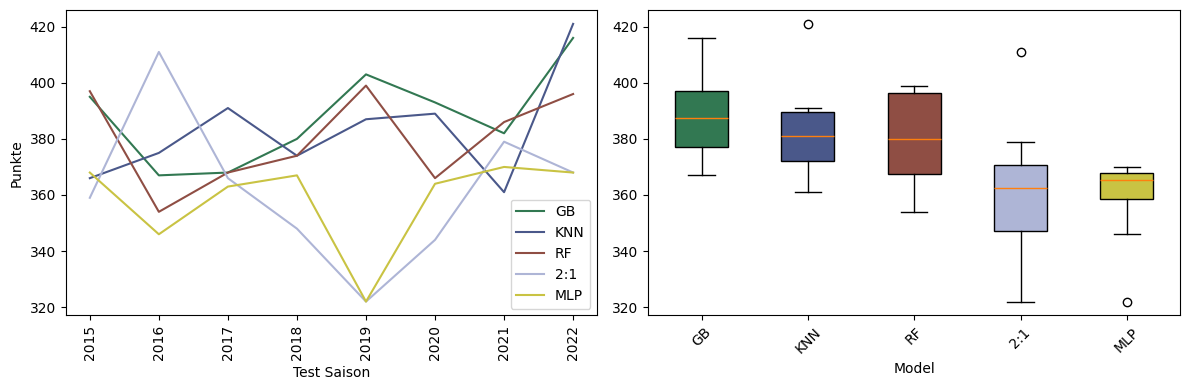

In [11]:
models = {
    "2:1": StaticEstimator([2, 1]),
    "RF": build_rf_model(rf_study),
    "GB": build_gb_model(gb_study),
    "KNN": build_knn_model(knn_study),
    "MLP": build_mlp_model(mlp_study),
}
color = [theme.BLUE_GRAY, theme.BROWNISH, theme.GRASS, theme.WHALE, theme.GOLD]

labels = list(models.keys())
scores = [
    cross_val_score(models[name], X_train, y_train, cv=splits, scoring=kicktipp_scoring)
    for name in models.keys()
]

fig, axs = cross_val_plot(df_matches, splits, labels, scores, color=color)

## Make test predictions

In [12]:
final_model = build_gb_model(gb_study)
final_model.fit(X_train, y_train)

df_matches_test = pd.read_pickle("data/matches_test.pickle")
X_test = df_matches_test[features]

y_pred = final_model.predict(X_test)
y_pred_raw = final_model.regressor.predict(X_test)

df_test_predictions = df_matches_test.copy()
df_test_predictions["host_goals_pred"] = y_pred[:, 0].astype(int)
df_test_predictions["guest_goals_pred"] = y_pred[:, 1].astype(int)
df_test_predictions["host_goals_pred_raw"] = y_pred_raw[:, 0]
df_test_predictions["guest_goals_pred_raw"] = y_pred_raw[:, 1]
df_test_predictions = df_test_predictions[
    [
        "season",
        "match_day",
        "host_name",
        "guest_name",
        "host_goals",
        "guest_goals",
        "host_goals_pred",
        "guest_goals_pred",
    ]
]
df_test_predictions.to_pickle("data/test_predictions.pickle")

In [13]:
df_matches_all = pd.read_pickle("data/matches_train_all.pickle")
X_train_all = df_matches_all[features]
y_train_all = df_matches_all[["host_goals", "guest_goals"]].values

final_model.fit(X_train_all, y_train_all)

df_matches_test = pd.read_pickle("data/matches_future.pickle")
X_test = df_matches_test[features]

y_pred = final_model.predict(X_test)
y_pred_raw = final_model.regressor.predict(X_test)

df_test_predictions = df_matches_test.copy()
df_test_predictions["host_goals_pred"] = y_pred[:, 0].astype(int)
df_test_predictions["guest_goals_pred"] = y_pred[:, 1].astype(int)
df_test_predictions["host_goals_pred_raw"] = y_pred_raw[:, 0]
df_test_predictions["guest_goals_pred_raw"] = y_pred_raw[:, 1]
df_test_predictions = df_test_predictions[
    [
        "season",
        "match_day",
        "host_id",
        "host_name",
        "guest_name",
        "guest_id",
        "host_goals",
        "guest_goals",
        "host_goals_pred",
        "guest_goals_pred",
    ]
]
df_test_predictions.to_pickle("data/future_predictions.pickle")